# Titanic - Machine Learning from Disaster

In [1]:
# pip install pandas_profiling

In [2]:
# pip install catboost

In [3]:
# conda install patool pyunpack

In [4]:
import os
import time
import re
from io import BytesIO
import requests
import json
import pyunpack
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
import math
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy import stats as st
import copy
from datetime import datetime
from scipy.stats import chi2_contingency, fisher_exact, pointbiserialr
from tqdm.notebook import tqdm

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB

random_state = 12345

## I. Task review

### **Short intro**
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

### **Customer**
The British shipping company, «White Star Line» (Kaggle's Prediction Competition)

### **Main goal**
1. We need to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

### **Work stages**
We need to:
1. Open and research files with data.
2. Find out what features have the importance on out target event - survive or not. Create additional features from provided data as it's possble for achiving best result on ML.
3. Prepare datas for further training for machine learning models.
4. Train ML models and find the best one with maximum of accuracy rate AUC-ROC. 
5. Check the accuracy of chosen model using test data (file from provided data).
6. Summarize the analysis and select the best solution/model to predict surviving passengers. Find out also cases of identifying between passengers and fact of their surviving to provide this information to interested companies.

### **Further use**
Probably shipping companies and insurance сompanies will be interested to know risks for different type of passengers and and to find weaknesses in the safety of passenger transportation.

### **Additional information**

Nothing

## II. Overview and data processing

### 1. Initial review

First, let's make a profile about the received initial data.

Let's download the source files with data `train.csv`, `test.csv` from the `kaggle`

``` ! kaggle competitions download -p {'datasets/'} -c titanic ```

```
pyunpack.Archive(
    'Desktop/Py_projects/jupyter/titanic/datasets/titanic.zip' # file path
).extractall(
    'Desktop/Py_projects/jupyter/titanic/datasets/') # unzip to dir
```

Then we'll reald files from `/titanic/datasets/` folder and save them to the variables of the same name:

In [5]:
def open_csv_file(file_name='', spreadsheet_id=''):
    pth1 = '/Users/vi_gav/Desktop/Py_projects/jupyter/titanic/datasets/' + file_name + '.csv'
    pth2 = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key=https://disk.yandex.kz/i/' + spreadsheet_id
    pth3 = '/kaggle/input'
    
    # find data sets on your laptop if you downloaded from kaggle
    if os.path.exists(pth1):
        df = pd.read_csv(pth1, parse_dates = [0])
        print('\nFile \033[4m\033[1m\033[31m{}\033[0m was read from your laptop'.format(file_name + '.csv'))
        print('_' * 135)
    
    # open files from cloud storage Yandex.Disk using spreadsheet_id as an agrument in function `open_csv_file`
    elif spreadsheet_id != '':
        try:
            r = requests.get(pth2)
            mybytes = BytesIO(r.content).read()
            download_url = mybytes.decode('utf-8').split(sep='"')[3]
            df = pd.read_csv(download_url, sep=',', error_bad_lines=False, comment='#' , encoding='cp1251')

            filename = download_url[download_url.rfind("filename=")+9:download_url.rfind("&disposition")]
        
            # download file and save it on your laptop
            print('Do you want to download file \033[4m\033[1m\033[31m{}\033[0m on your Desktop?'.format(filename), end='')
            download_file = str(input()).lower()
            if download_file in {'yes', 'y', '1'}:
                download_response = requests.get(download_url)
                with open('Desktop/' + filename, 'wb') as ouf:
                    ouf.write(download_response.content)
                print('File \033[4m\033[1m\033[31m{}\033[0m was read from cloud storage Yandex.Disk and saved on Desktop/'.format(filename))
                print('_' * 135)
            else:
                print('File \033[4m\033[1m\033[31m{}\033[0m was read from cloud storage Yandex.Disk'.format(filename))
                print('_' * 135)
        except:
            print('\033[4m\033[1m\033[31m{}\033[0m'.format('Something is wrong with url'))
            df = None
            
    # using kaggle cloud storage in kaggle notebook
    elif os.path.exists(pth3):
        # list of files
        print('Files in target directory:\n')
        for dirname, _, filenames in os.walk(pth3):
            for filename in filenames:
                print(os.path.join(dirname, filename))
        print('\nPlease, enter the file name you want to read\n')
        full_dir = dirname + '/' + str(input()+'.csv')
        df = pd.read_csv(full_dir)

    # error
    else:
        print('Something is wrong')
        
    return df

In [6]:
spreadsheet_ids = {'train':'oIMp3D3e_GHGlA',
                   'test':'uh1vK0WN-9XNgw',
                   'gender_submission':'Hcqc9VgKqA5zbg',
                   'target_test':'ykGIo9enSXNhzA'}

In [7]:
df, test = open_csv_file('train'), open_csv_file('test')


File train.csv was read from your laptop
_______________________________________________________________________________________________________________________________________

File test.csv was read from your laptop
_______________________________________________________________________________________________________________________________________


We will immediately bring the names of the signs to a single style

In [8]:
for df_name, data in {'train':df, 'test':test}.items():
    data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower() for name in data.columns]
    data.rename(columns={'pclass': 'p_class'}, inplace=True)
    print('\n\t\033[4m\033[1m\033[31m{}\033[0m'.format(df_name)) 
    display(data.head())
    print('_' * 135)


	train


,passenger_id,survived,p_class,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


_______________________________________________________________________________________________________________________________________

	test


,passenger_id,p_class,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


_______________________________________________________________________________________________________________________________________


And get a general information

In [9]:
# profile = ProfileReport(train, title="Pandas Profiling Report for train DF", 
#                         explorative=True)
# profile.to_widgets()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   passenger_id  891 non-null    object 
 1   survived      891 non-null    int64  
 2   p_class       891 non-null    int64  
 3   name          891 non-null    object 
 4   sex           891 non-null    object 
 5   age           714 non-null    float64
 6   sib_sp        891 non-null    int64  
 7   parch         891 non-null    int64  
 8   ticket        891 non-null    object 
 9   fare          891 non-null    float64
 10  cabin         204 non-null    object 
 11  embarked      889 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 83.7+ KB


In [11]:
df.describe()

,survived,p_class,age,sib_sp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In total we have next information according to provided data: 
    
**1. Table `df` (train sample for ML):** 

* `passenger_id` — unique passenger identifier
* `survived`— fact of survival, our target feature
* `p_class` — service class
* `name` — passenger's name
* `sex` — passenger's gender
* `age` — passenger's age, years
* `sib_sp` — of siblings / spouses aboard the Titanic
* `parch` — of parents / children aboard the Titanic
* `ticket` — ticket number 
* `fare` — сash expenses, conventional unit (c.u.)
* `cabin` — cabin number
* `embarked` — Port of Embarkation

Types of value in columns are — integers `int` and real numbers `float` и strings `object`.

We also see in the first view:
- missing values in columns `age` (19.9%), `cabin` (77.1%) and `embarked`. Total missing cells 8.1%.
- no duplicate rows.
- there are high correlation between several features.
- imbalance of classes 549 of 0 value and 342 of 1 value, which will need to be balanced in the future for better training of our models.
- dominated by middle-aged people from 20 to 40 years old and not so much fare 

### 2. Data analisys

#### 2.1 Checking for anomaly

In [12]:
df[df['fare'] < 6]

,passenger_id,survived,p_class,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0000,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0000,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0000,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0000,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0000,NaN,S
378,379,0,3,"Betros, Mr. Tannous",male,20.0,0,0,2648,4.0125,NaN,C
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0000,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0000,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0000,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0000,NaN,S


There are anomalies on the basis of spending money equal to 0 or too small, not corresponding to the passenger class. We will replace these values with the average for the class

In [13]:
def zero_to_median(column1, column2, treshgold, data):
    # column1 - column for grouping
    # column2 - target column for replace
    
    data_column1 = data[column1]
    
    for value in data_column1.unique():
        # calculate the median for group and display it
        median = data.loc[(data_column1 == value), column2].median()
        
        # median for each class
        print(f'For {column1} {value} median is {median:.1f}')
        
        # replace abnormal values on the median
        data.loc[(data[column2] < treshgold) | (data[column2].isna()) & (data_column1 == value), column2] = median

In [14]:
zero_to_median('p_class', 'fare', 6, df)

For p_class 3 median is 8.1
For p_class 1 median is 60.3
For p_class 2 median is 14.2


In [15]:
zero_to_median('p_class', 'fare', 6, test)

For p_class 3 median is 7.9
For p_class 2 median is 15.8
For p_class 1 median is 60.0


Then we will divide all spending into 9 groups with the condition that in each class people's behavior regarding money can be: budgetary, sufficient, excessive

In [16]:
def quantile_for_col(data, column):
    
    new_df = pd.DataFrame(columns=list(data.columns) + ['quantile_'+column])

    print('Shape of an origin DF is', data.shape[0])

    for clss in data['p_class'].unique():
        bin_labels_3 = [str(clss) + '_budgetary', str(clss) + '_sufficient', str(clss) + '_excessive']
        temp_df = data.query('p_class == @clss')
        temp_df['quantile_'+column] = pd.qcut(data.query('p_class == @clss')[column], q=3, labels=bin_labels_3)
        new_df = pd.concat([new_df, temp_df])
    
    new_df['passenger_id'] = new_df['passenger_id'].astype('int')
    data = new_df.sort_values(by='passenger_id', ascending=True).reset_index(drop=True)

    print('Shape after split DF is', data.shape[0])
    
    return data

In [17]:
df = quantile_for_col(df, 'fare')

Shape of an origin DF is 891
Shape after split DF is 891


In [18]:
test = quantile_for_col(test, 'fare')

Shape of an origin DF is 418
Shape after split DF is 418


In [19]:
df['quantile_fare'].value_counts()

3_budgetary     167
3_excessive     164
3_sufficient    160
2_budgetary      84
1_sufficient     73
1_budgetary      72
1_excessive      71
2_sufficient     61
2_excessive      39
Name: quantile_fare, dtype: int64

In [20]:
df.head(5)

,passenger_id,survived,p_class,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked,quantile_fare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,3_budgetary
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1_sufficient
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3_sufficient
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1_sufficient
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,3_sufficient


#### 2.2 Missing values and adding features

As we alredry have found out there are some missing values in columns `age`, `cabin` and `embarked`. 

**Column `cabin`**

In [21]:
df['cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

Information about cabin can be usefull but unfortunately it is not possible to recover lost or missed values. Therefore we'll save only letter designation and for `NaN` will use `unknown`

In [22]:
df[df['cabin'].notna()]['cabin'].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: cabin, dtype: object

In [23]:
# find out class of cabin
def cabin_classification(cabin):
    return cabin[0]

# fill NaN values to `unknown`
for df_name, data in {'train':df, 'test':test}.items():
    data['cabin'] = data['cabin'].fillna(value='N') # N - unknown
    data['cabin_classification'] = data[data['cabin'].notna()]['cabin'].apply(cabin_classification)
    
    print('\n\t\033[4m\033[1m\033[31m{}\033[0m'.format(df_name)) 
    display(data.head(3))
    print('_' * 135)


	train


,passenger_id,survived,p_class,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked,quantile_fare,cabin_classification
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,N,S,3_budgetary,N
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1_sufficient,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,N,S,3_sufficient,N


_______________________________________________________________________________________________________________________________________

	test


,passenger_id,p_class,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked,quantile_fare,cabin_classification
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,N,Q,3_sufficient,N
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,N,S,3_budgetary,N
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,N,Q,2_budgetary,N


_______________________________________________________________________________________________________________________________________


---

**Column `age`**

In [24]:
print('In column age {}% missing values of full Data Frame'.format(
    round(len(df[df['age'].isna()]) / df.shape[0] * 100, 2))
     )

In column age 19.87% missing values of full Data Frame


It's too much for deleting

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   passenger_id          891 non-null    int64  
 1   survived              891 non-null    object 
 2   p_class               891 non-null    object 
 3   name                  891 non-null    object 
 4   sex                   891 non-null    object 
 5   age                   714 non-null    float64
 6   sib_sp                891 non-null    object 
 7   parch                 891 non-null    object 
 8   ticket                891 non-null    object 
 9   fare                  891 non-null    float64
 10  cabin                 891 non-null    object 
 11  embarked              889 non-null    object 
 12  quantile_fare         891 non-null    object 
 13  cabin_classification  891 non-null    object 
dtypes: float64(2), int64(1), object(11)
memory usage: 97.6+ KB


In [26]:
zero_to_median('quantile_fare', 'age', 1, df)

For quantile_fare 3_budgetary median is 24.5
For quantile_fare 1_sufficient median is 37.0
For quantile_fare 3_sufficient median is 26.0
For quantile_fare 3_excessive median is 19.5
For quantile_fare 2_excessive median is 24.2
For quantile_fare 1_budgetary median is 45.0
For quantile_fare 2_sufficient median is 30.0
For quantile_fare 2_budgetary median is 30.0
For quantile_fare 1_excessive median is 35.0


(0.0, 100.0)

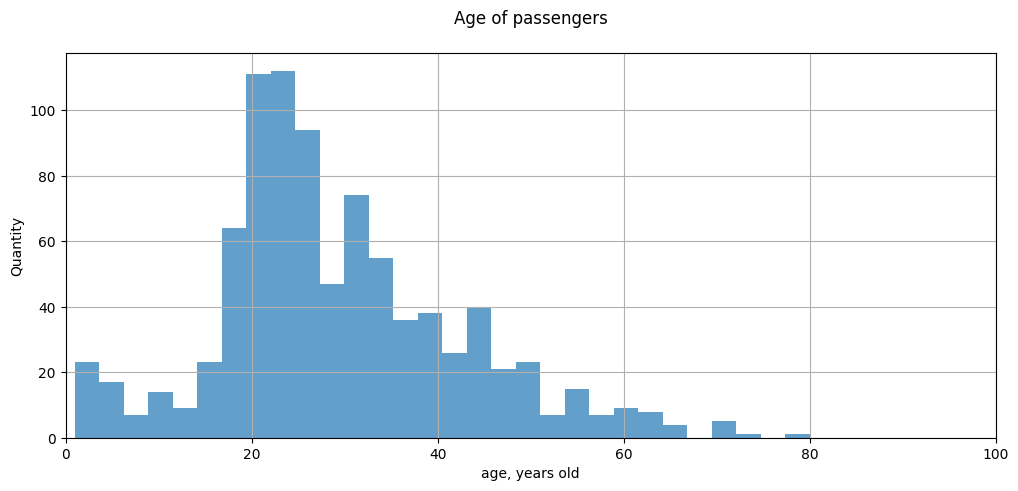

In [27]:
df['age'].hist(bins = 30, 
                 figsize=(12, 5),
                 grid=True,
                 alpha=0.7)
plt.title('Age of passengers'+ "\n")
plt.xlabel('age, years old')
plt.ylabel('Quantity')
plt.xlim(0, 100)

Let's agree that up to 12 years old children are absolutely not independent. Then we will divide according to the following logic:

* ... < 12 y.o. - category `child`
* 12 - 17 y.o. - category `teen`
* 18-35 y.o. - category `young`
* 36 - 60 y.o. - category `adult`
* 60 < ... y.o. - category `old`

In [28]:
# find out age group
def age_group(age):
    if age < 12:
        return 'child'
    if 12 <= age < 18:
        return 'teen'
    if 18 <= age <= 35:
        return 'young'
    if 36 <= age <= 60:
        return 'adult'
    return 'old'

df['age_group'] = df['age'].apply(age_group)
test['age_group'] = test['age'].apply(age_group)

Text(0, 0.5, 'Quantity')

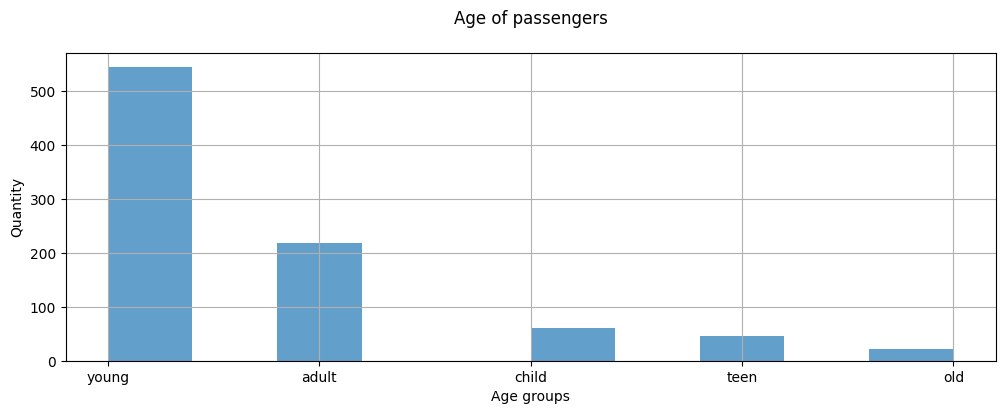

In [29]:
df['age_group'].hist( 
                 figsize=(12, 4),
                 grid=True,
                 alpha=0.7)
plt.title('Age of passengers'+ "\n")
plt.xlabel('Age groups')
plt.ylabel('Quantity')

Repeat for the test sample 

In [30]:
zero_to_median('quantile_fare', 'age', 1, test)
test['age_group'] = test['age'].apply(age_group)

For quantile_fare 3_sufficient median is 24.0
For quantile_fare 3_budgetary median is 24.5
For quantile_fare 2_budgetary median is 26.0
For quantile_fare 3_excessive median is 22.5
For quantile_fare 2_excessive median is 24.0
For quantile_fare 1_budgetary median is 42.0
For quantile_fare 1_sufficient median is 44.0
For quantile_fare 2_sufficient median is 29.0
For quantile_fare 1_excessive median is 39.0


---

**Column `name`**

In the `name` column we have useless information related only with a specific person so I propose to make it a little more useful

In [31]:
# find out the last name
def family_detection(name):
    return name.split(sep=',')[0] 

for df_name, data in {'train':df, 'test':test}.items():
    data['family'] = data['name'].apply(family_detection)

Now we have a last name of each person. And let's count people with tha same last names, it can be namesakes and people from the same family

In [32]:
# find out how many namesakes
def same_last_names(family):
    try:
        return (df[df['family'] == family]['family'].count() + test[test['family'] == family]['family'].count())
    except:
        return (df[df['family'] == family]['family'].count())

df['same_last_name'] = df['family'].apply(same_last_names)
test['same_last_name'] = test['family'].apply(same_last_names)

In [33]:
df.head(3)

,passenger_id,survived,p_class,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked,quantile_fare,cabin_classification,age_group,family,same_last_name
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,N,S,3_budgetary,N,young,Braund,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1_sufficient,C,adult,Cumings,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,N,S,3_sufficient,N,young,Heikkinen,1


---

**Column `embarked`**

In [34]:
df[df['embarked'].isna()]

,passenger_id,survived,p_class,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked,quantile_fare,cabin_classification,age_group,family,same_last_name
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1_sufficient,B,adult,Icard,1
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1_sufficient,B,old,Stone,1


Just 2 objects, so let's drop it

In [35]:
df = df.dropna(subset=['embarked']).reset_index(drop=True) 

In [36]:
df.shape

(889, 17)

#### 2.3 Checking for obvious duplicates

In [37]:
print('Duplicates in \033[4m\033[1m\033[31mtrain.csv\033[0m:', df.duplicated().sum())
print('-' * 25)

Duplicates in train.csv: 0
-------------------------


#### 2.4 Categorization of features

We have signs presented in the form of strings that models will not be able to work with. We looked at the unique values of the columns in advance. Therefore, we apply the OHE method for:
- Variants of `Female` and `Male`:
    - `sex`

In [38]:
df = pd.get_dummies(df, columns=['sex'], drop_first=True)

In [39]:
test = pd.get_dummies(test, columns=['sex'], drop_first=True)

In [40]:
df.head(2)

,passenger_id,survived,p_class,name,age,sib_sp,parch,ticket,fare,cabin,embarked,quantile_fare,cabin_classification,age_group,family,same_last_name,sex_male
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,N,S,3_budgetary,N,young,Braund,2,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,1_sufficient,C,adult,Cumings,2,0


The second type of problem signs are multiple types. Let's use ordinal coding to assign a label to each type. And bring them out
- `embarked` : S, C, Q
- `cabin_classification` : A, B, C, D, E, F, G, T and N for NaN (unknown values)
- `age_group` : young, adult, child, teen, old
- `quantile_fare` : class - 1, 2 , 3 and budgetary, sufficient, excessive
- `family` : too many unique values

In [41]:
# create dict for families
lst_family = list(df['family'].unique())
lst_label = [x for x in range(len(lst_family))]
family_dic = dict(zip(lst_family, lst_label))

In [42]:
# func for checking family in the dictionary, labling it and add new objects if it's necessary 
def family_labling(family):
    if family in family_dic:
        return family_dic[family]
    else:
        family_dic[family] = list(family_dic.items())[-1][1] + 1
        return family_dic[family]

In [43]:
df['family_label'] = df['family'].apply(family_labling)
test['family_label'] = test['family'].apply(family_labling)

In [44]:
encoder = OrdinalEncoder()
df_ordinal = pd.DataFrame(encoder.fit_transform(df[
    ['embarked', 'cabin_classification', 'age_group', 'quantile_fare']
]), columns=['embarked_label', 'cabin_classification_label', 'age_group_label', 'quantile_fare_label'])

encoder.categories_

[array(['C', 'Q', 'S'], dtype=object),
 array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'N', 'T'], dtype=object),
 array(['adult', 'child', 'old', 'teen', 'young'], dtype=object),
 array(['1_budgetary', '1_excessive', '1_sufficient', '2_budgetary',
        '2_excessive', '2_sufficient', '3_budgetary', '3_excessive',
        '3_sufficient'], dtype=object)]

Markers are assigned accordingly:

- embarked : C = 0, Q =1, S = 2
- cabin_classification : A = 0, B = 1, C = 2, D = 3, E = 4, F = 5, G = 6, T = 8 and N =7 for NaN (unknown values)
- age_group : adult = 0, child = 1, old = 2, teen =3, young = 4
- quantile_fare : 1_budgetary = 0, 1_excessive = 1, 1_sufficient = 2, 
    2_budgetary = 3, 2_excessive = 4, 2_sufficient = 5, 
    3_budgetary = 6, 3_excessive = 7, 3_sufficient = 8

In [45]:
df_ordinal.columns

Index(['embarked_label', 'cabin_classification_label', 'age_group_label',
       'quantile_fare_label'],
      dtype='object')

In [46]:
df = (pd.concat([df,df_ordinal],sort=False,axis=1) # join new columns
     )

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   passenger_id                889 non-null    int64  
 1   survived                    889 non-null    object 
 2   p_class                     889 non-null    object 
 3   name                        889 non-null    object 
 4   age                         889 non-null    float64
 5   sib_sp                      889 non-null    object 
 6   parch                       889 non-null    object 
 7   ticket                      889 non-null    object 
 8   fare                        889 non-null    float64
 9   cabin                       889 non-null    object 
 10  embarked                    889 non-null    object 
 11  quantile_fare               889 non-null    object 
 12  cabin_classification        889 non-null    object 
 13  age_group                   889 non

For test sample:

In [48]:
test_ordinal = pd.DataFrame(encoder.transform(test[
    ['embarked', 'cabin_classification', 'age_group', 'quantile_fare']
]), columns=['embarked_label', 'cabin_classification_label', 'age_group_label', 'quantile_fare_label'])

In [49]:
test = (pd.concat([test,test_ordinal],sort=False,axis=1) # join new columns
     )

---

In [50]:
def alone_def(row):
    sib_sp = row['sib_sp']
    parch = row['parch']
    
    if sib_sp + parch > 0:
        return 1
    return 0

In [51]:
df['alone_yes'] = df.apply(alone_def, axis=1)

In [52]:
test['alone_yes'] = df.apply(alone_def, axis=1)

---

In [53]:
# passengers priority due the evacuation
def evacuation_priority(row):
    age_group = row['age_group']
    sex_male = row['sex_male']
    sib_sp = row['sib_sp']
    parch = row['parch']
    p_class = row['p_class']
    
    if age_group in ['child', 'teen']:
        return 0
    if sex_male == 0 and age_group in ['young', 'adult']: #female
        if p_class == 1:
            return 1
        elif p_class == 2:
            return 2
        return 3
    if sex_male == 1 and age_group in ['young', 'adult'] and sib_sp == 0 and parch > 0: #male with a child without wife
        if p_class == 1:
            return 4
        elif p_class == 2:
            return 5
        return 6
    return 7

In [54]:
df['evacuation_priority'] = df.apply(evacuation_priority, axis=1)

In [55]:
test['evacuation_priority'] = test.apply(evacuation_priority, axis=1)

### 3. Research analysis

#### 3.1. Initial examination of features

Let's look at the distribution of numeric features. We will immediately exclude profile data and duplicate features: the unique passenger number, name and ticket, cabin, categorical features and the target feature.

In [56]:
df.columns

Index(['passenger_id', 'survived', 'p_class', 'name', 'age', 'sib_sp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked', 'quantile_fare',
       'cabin_classification', 'age_group', 'family', 'same_last_name',
       'sex_male', 'family_label', 'embarked_label',
       'cabin_classification_label', 'age_group_label', 'quantile_fare_label',
       'alone_yes', 'evacuation_priority'],
      dtype='object')

array([[<AxesSubplot:title={'center':'sex_male'}>,
        <AxesSubplot:title={'center':'family_label'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'evacuation_priority'}>,
        <AxesSubplot:title={'center':'cabin_classification_label'}>,
        <AxesSubplot:title={'center':'embarked_label'}>],
       [<AxesSubplot:title={'center':'alone_yes'}>,
        <AxesSubplot:title={'center':'age_group_label'}>,
        <AxesSubplot:title={'center':'same_last_name'}>],
       [<AxesSubplot:title={'center':'fare'}>,
        <AxesSubplot:title={'center':'quantile_fare_label'}>,
        <AxesSubplot:>]], dtype=object)

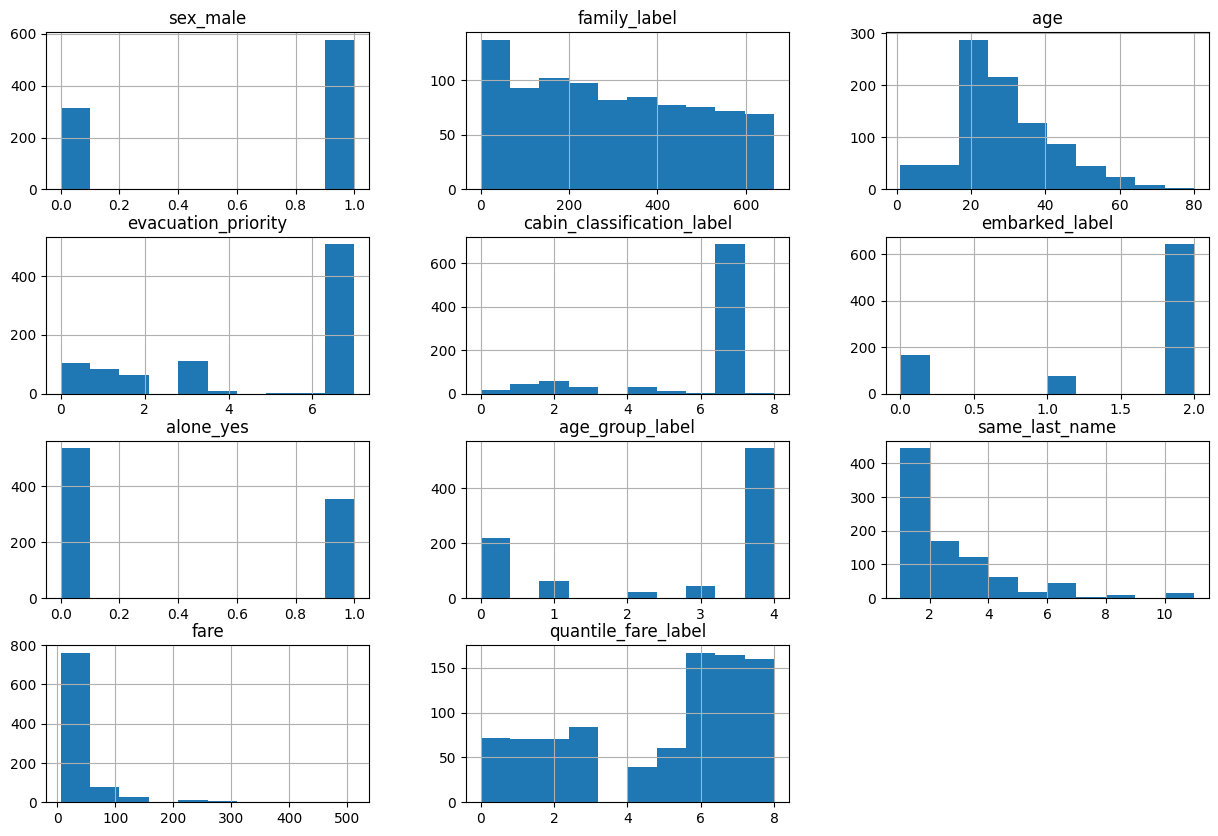

In [57]:
features_correlation = list(set(df.columns) - set(
    ['passenger_id','survived','name','ticket','cabin',
     'family', 'quantile_fare']))
df[features_correlation].hist(figsize=(15,10))

In [58]:
# part output function
def part_group(column, value, describe):
    k = df[df[column] == value]['passenger_id'].count() / df.shape[0]
    print(f'Part \033[4m\033[1m\033[31m{describe}\033[0m is \033[4m\033[1m\033[31m{k:.2%}\033[0m of the total number of passengers')

In [59]:
df.columns

Index(['passenger_id', 'survived', 'p_class', 'name', 'age', 'sib_sp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked', 'quantile_fare',
       'cabin_classification', 'age_group', 'family', 'same_last_name',
       'sex_male', 'family_label', 'embarked_label',
       'cabin_classification_label', 'age_group_label', 'quantile_fare_label',
       'alone_yes', 'evacuation_priority'],
      dtype='object')

In [60]:
part_group('p_class', 3, '3-class')
part_group('quantile_fare_label', 6, '3rd class with the behavior characteristic of Economy')
part_group('evacuation_priority', 3, 'females with a child from 3 class')
print()
part_group('alone_yes', 0, 'not alone')
part_group('sib_sp', 0, 'without any spouse')
part_group('parch', 0, 'without any child')
print()
part_group('evacuation_priority', 0, 'childs')
part_group('sex_male', 1, 'males')
part_group('age_group_label', 4, 'young people')
part_group('age_group_label', 0, 'adult people')
print()
part_group('embarked_label', 2, 'S-departure')
part_group('cabin_classification_label', 7, 'unknown cabin class')
part_group('cabin_classification_label', 2, 'C-class cabin')

Part 3-class is 55.23% of the total number of passengers
Part 3rd class with the behavior characteristic of Economy is 18.79% of the total number of passengers
Part females with a child from 3 class is 12.37% of the total number of passengers

Part not alone is 60.18% of the total number of passengers
Part without any spouse is 68.17% of the total number of passengers
Part without any child is 76.04% of the total number of passengers

Part childs is 11.92% of the total number of passengers
Part males is 64.90% of the total number of passengers
Part young people is 61.19% of the total number of passengers
Part adult people is 24.52% of the total number of passengers

Part S-departure is 72.44% of the total number of passengers
Part unknown cabin class is 77.28% of the total number of passengers
Part C-class cabin is 6.64% of the total number of passengers


#### 3.2. Analysis of correlations of categorical features

Let's separate categorical features into a separate variable

In [61]:
cat_features = ['p_class','sib_sp', 'parch', 'quantile_fare_label',
                'embarked', 'cabin_classification', 'age_group', 'sex_male', 'alone_yes', 'evacuation_priority']

Let's study the correlation of binary features using the phi coefficient

In [62]:
phik_overview = df[cat_features + ['survived']].phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['quantile_fare_label', 'sex_male', 'alone_yes', 'evacuation_priority']


,p_class,sib_sp,parch,quantile_fare_label,embarked,cabin_classification,age_group,sex_male,alone_yes,evacuation_priority,survived
p_class,1.00,0.22,0.03,1.00,0.58,0.88,0.37,0.08,0.08,0.71,0.20
sib_sp,0.22,1.00,0.59,0.50,0.14,0.03,0.40,0.20,0.77,0.36,0.18
parch,0.03,0.59,1.00,0.43,0.08,0.06,0.39,0.23,0.64,0.41,0.15
quantile_fare_label,1.00,0.50,0.43,1.00,0.65,0.76,0.48,0.34,0.72,0.64,0.38
embarked,0.58,0.14,0.08,0.65,1.00,0.38,0.13,0.07,0.07,0.38,0.10
cabin_classification,0.88,0.03,0.06,0.76,0.38,1.00,0.31,0.18,0.19,0.43,0.32
age_group,0.37,0.40,0.39,0.48,0.13,0.31,1.00,0.10,0.28,0.68,0.08
sex_male,0.08,0.20,0.23,0.34,0.07,0.18,0.10,1.00,0.46,0.99,0.75
alone_yes,0.08,0.77,0.64,0.72,0.07,0.19,0.28,0.46,1.00,0.61,0.31
evacuation_priority,0.71,0.36,0.41,0.64,0.38,0.43,0.68,0.99,0.61,1.00,0.76


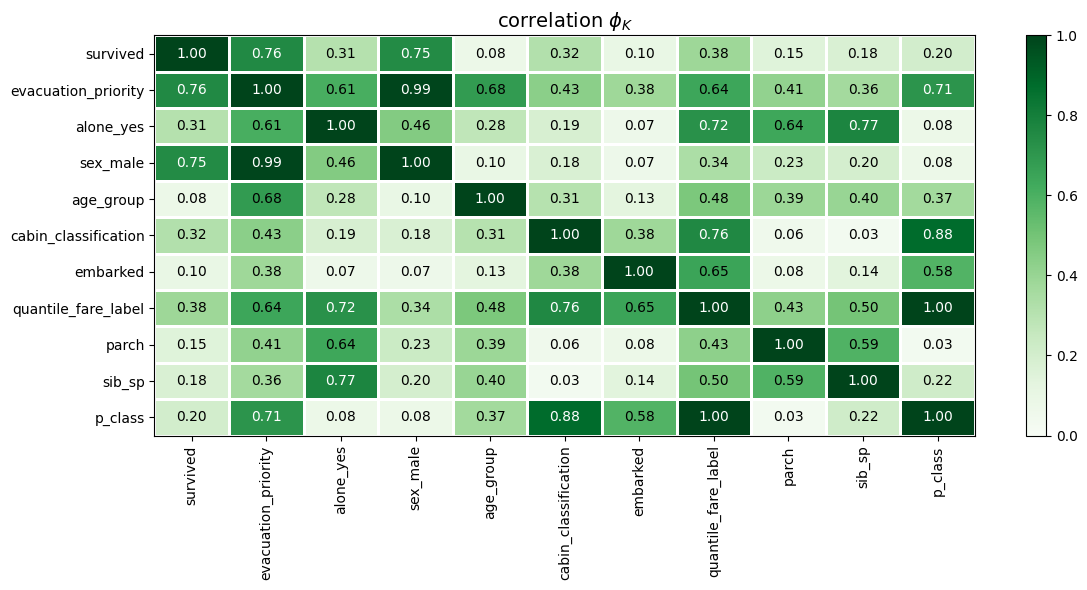

In [63]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(12, 6))
plt.tight_layout()

Immediately look at:

- there is a direct dependence of the passenger's survival on the evacuation procedure agreed in such cases and gender identity;
- the evacuation procedure directly depends on the age, gender, the presence of a child and the class of service;
- in general multicollinearity of features dependent on each other is observed.

For categorical features we will also research the relationship based on conjugacy tables (cross-tables).

In [64]:
def corr_cat(cat_feature, target):
    print('\n', 'The relationship of feature \033[4m\033[1m\033[31m{}\033[0m to target feature \033[4m\033[1m\033[31m{}\033[0m:'
          .format(cat_feature, 'target'))
    print('\n \033[4m\033[1m\033[31m{}\033[0m'.format('Cross-table:'))
    display(pd.crosstab(df[cat_feature], df[target]))
    sns.heatmap(pd.crosstab(df[cat_feature], df[target]), 
            cmap="YlGnBu", annot=True, cbar=False)
    plt.title('Heatmap of quantitative relations')
    plt.show()
    
    result_pvalue = chi2_contingency(pd.crosstab(df[cat_feature], df[target]))[1]
    print('P-value is:', result_pvalue)
    if (result_pvalue < alpha):
        print('The relationship \033[4m\033[1m\033[31m{}\033[0m statistically \033[4m\033[1m\033[31m{}\033[0m'.format('is','confirmed'))
    else:
        print('The relationship \033[4m\033[1m\033[31m{}\033[0m statistically \033[4m\033[1m\033[31m{}\033[0m'.format("isn't",'confirmed'))
    print('\n' , '--' * 40)


 The relationship of feature p_class to target feature target:

 Cross-table:


survived,0,1
p_class,,
1,80,134
2,97,87
3,372,119


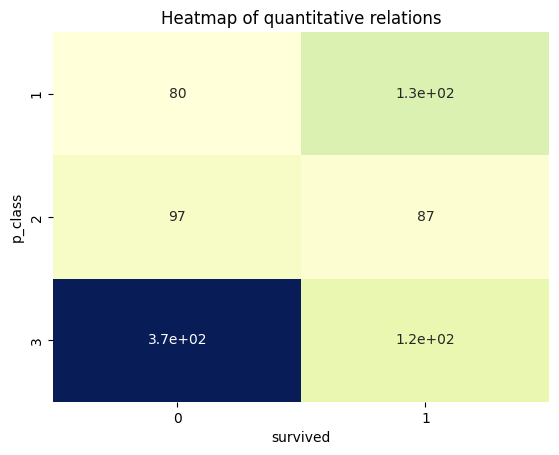

P-value is: 1.1813624785477922e-22
The relationship is statistically confirmed

 --------------------------------------------------------------------------------

 The relationship of feature sib_sp to target feature target:

 Cross-table:


survived,0,1
sib_sp,,
0,398,208
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


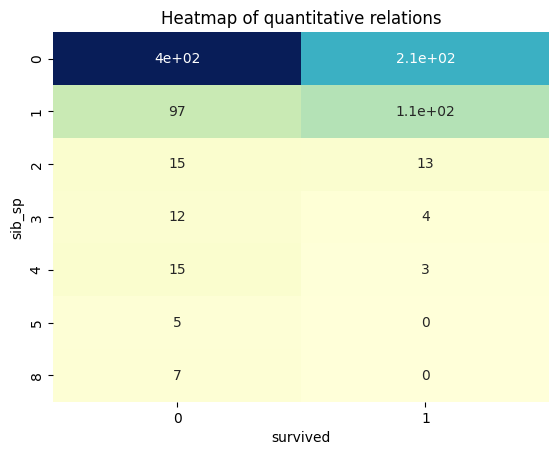

P-value is: 1.2620136275676984e-06
The relationship is statistically confirmed

 --------------------------------------------------------------------------------

 The relationship of feature parch to target feature target:

 Cross-table:


survived,0,1
parch,,
0,445,231
1,53,65
2,40,40
3,2,3
4,4,0
5,4,1
6,1,0


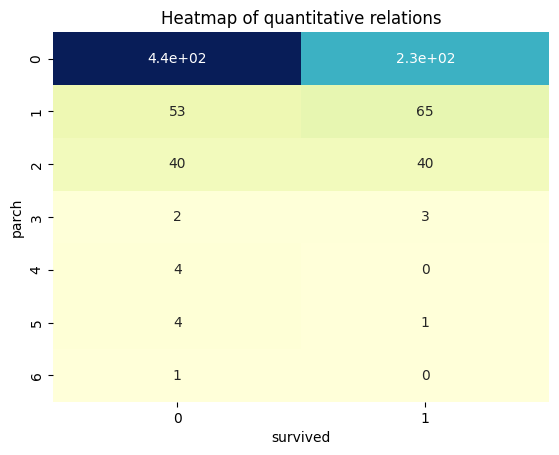

P-value is: 7.896496976051095e-05
The relationship is statistically confirmed

 --------------------------------------------------------------------------------

 The relationship of feature quantile_fare_label to target feature target:

 Cross-table:


survived,0,1
quantile_fare_label,,
0.0,40,32
1.0,16,55
2.0,24,47
3.0,55,29
4.0,16,23
5.0,26,35
6.0,125,42
7.0,112,52
8.0,135,25


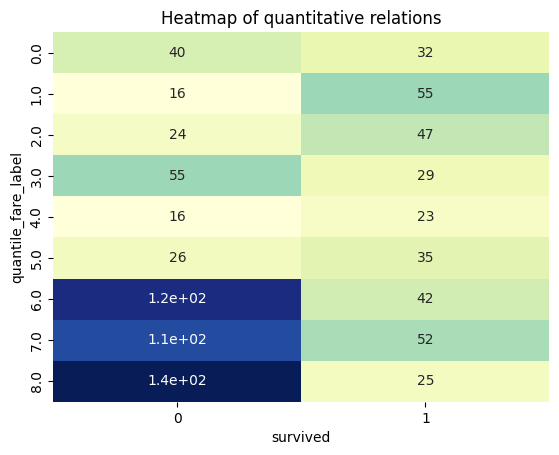

P-value is: 7.145085117358205e-26
The relationship is statistically confirmed

 --------------------------------------------------------------------------------

 The relationship of feature embarked to target feature target:

 Cross-table:


survived,0,1
embarked,,
C,75,93
Q,47,30
S,427,217


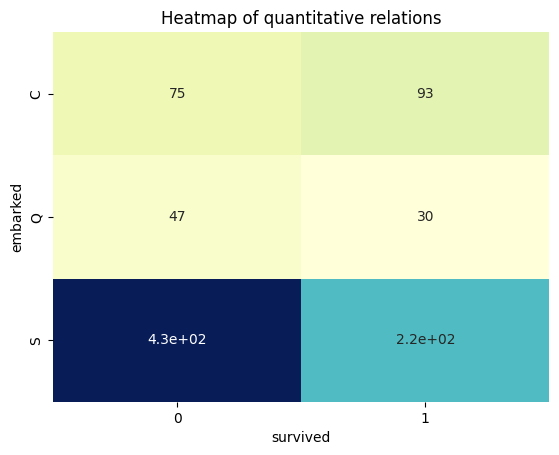

P-value is: 1.769922284120912e-06
The relationship is statistically confirmed

 --------------------------------------------------------------------------------

 The relationship of feature cabin_classification to target feature target:

 Cross-table:


survived,0,1
cabin_classification,,
A,8,7
B,12,33
C,24,35
D,8,25
E,8,24
F,5,8
G,2,2
N,481,206
T,1,0


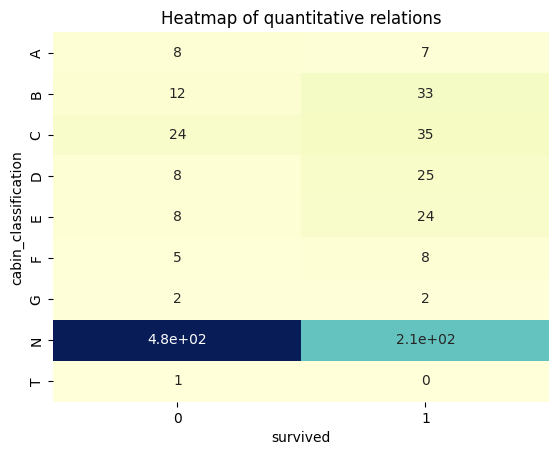

P-value is: 2.0576925539801955e-17
The relationship is statistically confirmed

 --------------------------------------------------------------------------------

 The relationship of feature age_group to target feature target:

 Cross-table:


survived,0,1
age_group,,
adult,131,87
child,29,32
old,17,4
teen,23,22
young,349,195


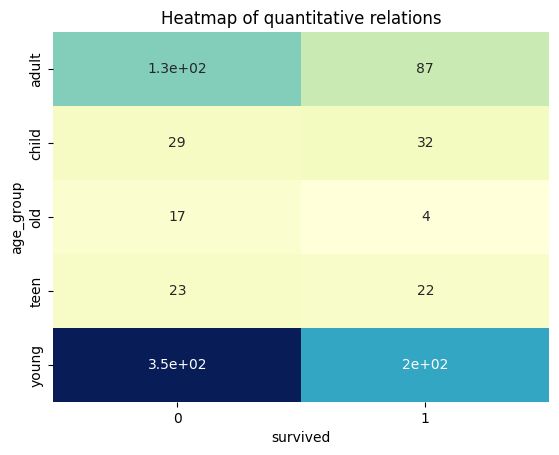

P-value is: 0.015687041163867023
The relationship is statistically confirmed

 --------------------------------------------------------------------------------

 The relationship of feature sex_male to target feature target:

 Cross-table:


survived,0,1
sex_male,,
0,81,231
1,468,109


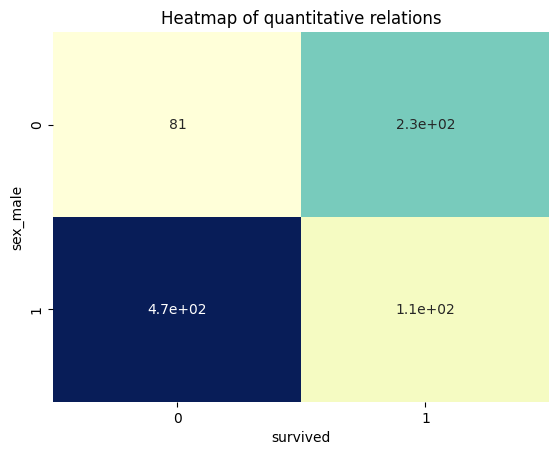

P-value is: 3.7799096665576e-58
The relationship is statistically confirmed

 --------------------------------------------------------------------------------

 The relationship of feature alone_yes to target feature target:

 Cross-table:


survived,0,1
alone_yes,,
0,374,161
1,175,179


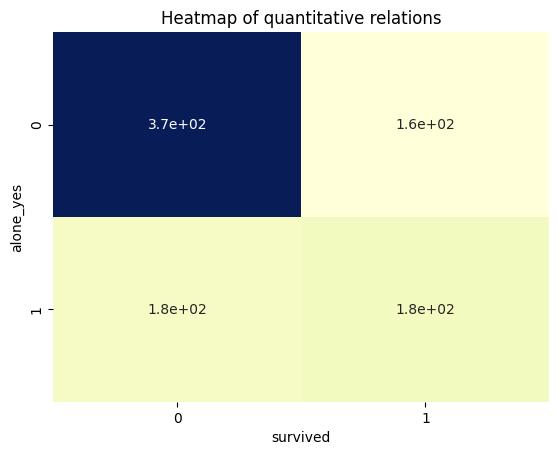

P-value is: 1.2184807337771435e-09
The relationship is statistically confirmed

 --------------------------------------------------------------------------------

 The relationship of feature evacuation_priority to target feature target:

 Cross-table:


survived,0,1
evacuation_priority,,
0,52,54
1,2,81
2,6,58
3,56,54
4,8,2
5,2,1
6,3,1
7,420,89


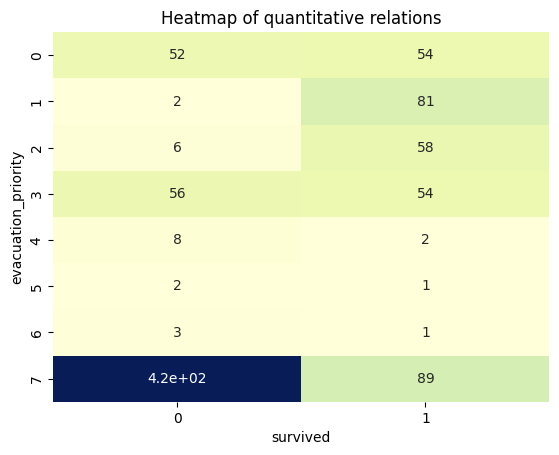

P-value is: 4.157498428522745e-62
The relationship is statistically confirmed

 --------------------------------------------------------------------------------


In [65]:
alpha = 0.05

for cat_feature in cat_features:
    corr_cat(cat_feature, 'survived')

Thus it can be argued that all of the available features have a direct connection with the target feature.

Among the features the following trends are observed:
- Among all the passengers on board:
    * almost `62%` of the first class survived, 
    * `47%` of the second 
    * and only `24%` of the third class. 

This distribution of deaths is primarily due to the placement of cabins of different classes on the ship: the lower the service status, the lower the deck. Most of the dead most likely did not even reach the lifeboats.
- Most of the single passengers (`68%`) without children (`76%`) are mainly young people from 18 to 35 years old (`61%`).
- However, during the disaster, 90% of all children on board were saved due to the evacuation order.
- A high percentage of survivors turned out to be among first-class passengers with a significant fortune which they were willing to spend and economy class with average income - there is an assumption that during the collision with the iceberg, these people were as usual in some entertainment institution - restaurant, casino and so on.
- `72%` of all passengers boarded at point S, `51%` of them survived.
- According to statistics the evacuation of passengers took place in the following order: 
    * first women and children, 
    * passengers with children
    * and last of all the elderly and men of economy class. 
- `74%` of all women survived 
- while `81%` of male passengers died.

### 4. Analysis of correlations of quantitative features

In [66]:
features_correlation_num = list(set(df.columns) - 
                                set(['passenger_id','survived','name','ticket', 'cabin_classification_label', 'quantile_fare',
                                     'cabin','family','family_label', 'age_group_label', 'embarked_label', 'alone']) - 
                                set(cat_features))

Let's build a matrix of diagrams where we see the distributions of signs on the main diagonal, and outside the main diagonal – the scattering diagrams for pairs of signs (we indicate the fact of survival as the target feature)

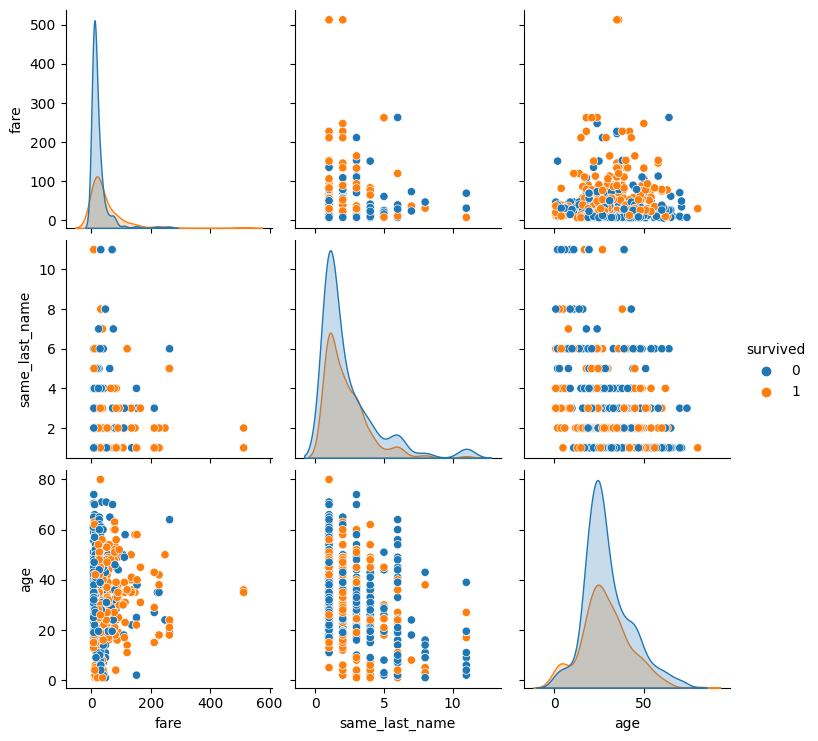

In [67]:
sns.pairplot(df[features_correlation_num + ['survived']], hue='survived')

We will also output the correlation in the form of a table for quantitative features

In [68]:
(df[features_correlation_num + ['survived']]).corr()

,fare,same_last_name,age
fare,1.000000,0.145323,0.116345
same_last_name,0.145323,1.000000,-0.230939
age,0.116345,-0.230939,1.000000


In the case of a binary categorical feature and a numerical feature we can also apply a biserial correlation coefficient.

In [69]:
for num_feature in features_correlation_num:
    print('\nThe feature \033[4m\033[1m\033[31m{}\033[0m:'.format(num_feature))
    print(pointbiserialr(df[num_feature], df['survived']))
    
    result_pvalue_num = pointbiserialr(df[num_feature], df['survived'])[1]
    if (result_pvalue_num < alpha):
        print('The relationship \033[4m\033[1m\033[31m{}\033[0m statistically \033[4m\033[1m\033[31m{}\033[0m'.format('is','confirmed'))
    else:
        print('The relationship \033[4m\033[1m\033[31m{}\033[0m statistically \033[4m\033[1m\033[31m{}\033[0m'.format("isn't",'confirmed'))
    print('--' * 40)


The feature fare:
PointbiserialrResult(correlation=0.2538021059502438, pvalue=1.5554288532627446e-14)
The relationship is statistically confirmed
--------------------------------------------------------------------------------

The feature same_last_name:
PointbiserialrResult(correlation=-0.02369357872848927, pvalue=0.48046475070453926)
The relationship isn't statistically confirmed
--------------------------------------------------------------------------------

The feature age:
PointbiserialrResult(correlation=-0.039805690430512734, pvalue=0.2357603061685177)
The relationship isn't statistically confirmed
--------------------------------------------------------------------------------


### 5. Data split on samples

#### 5.1. First feature cleaning

In [70]:
df.columns

Index(['passenger_id', 'survived', 'p_class', 'name', 'age', 'sib_sp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked', 'quantile_fare',
       'cabin_classification', 'age_group', 'family', 'same_last_name',
       'sex_male', 'family_label', 'embarked_label',
       'cabin_classification_label', 'age_group_label', 'quantile_fare_label',
       'alone_yes', 'evacuation_priority'],
      dtype='object')

Let's delete features don't affect on final target question or duplicate each other:
- unique passenger identifier (passenger_id)
- passenger's name (name, family)
- ticket number
- cabin number and cabin_classification
- same_last_name
- embarked
- sib_sp and parch
- quantile_fare

In [71]:
filtered_pas_lst = df.drop(
    columns = ['passenger_id', 'name', 'family', 'ticket', 'age_group',
               'cabin', 'cabin_classification', 'same_last_name', 
               'embarked', 'sib_sp', 'parch', 'sib_sp', 'parch','quantile_fare'],
    axis = 1)

In [72]:
print('The shape of Data Frame:', filtered_pas_lst.shape)
filtered_pas_lst.head()

The shape of Data Frame: (889, 12)


,survived,p_class,age,fare,sex_male,family_label,embarked_label,cabin_classification_label,age_group_label,quantile_fare_label,alone_yes,evacuation_priority
0,0,3,22.0,7.2500,1,0,2.0,7.0,4.0,6.0,1,7
1,1,1,38.0,71.2833,0,1,0.0,2.0,0.0,2.0,1,1
2,1,3,26.0,7.9250,0,2,2.0,7.0,4.0,8.0,0,3
3,1,1,35.0,53.1000,0,3,2.0,2.0,4.0,2.0,1,1
4,0,3,35.0,8.0500,1,4,2.0,7.0,4.0,8.0,0,7


#### 5.1. Data split

According to provided data we have already splited samples for train and test. So we need to separate our target feature: column `survived`

In [73]:
features = filtered_pas_lst.drop(['survived'], axis = 1)
features['p_class'] = features['p_class'].astype('int')

target = filtered_pas_lst['survived'].astype('int')

# add samples in dictionary
arrays = {
    'train' : features,
    'test' : test}

# and display contained objects
for array_name, array in arrays.items():
    print("\033[4m\033[1m\033[31m{}\033[0m contain objects:".format(f'{array_name} sample'), 
          array.shape[0], f'({array.shape[0]/filtered_pas_lst.shape[0]:.1%})')

train sample contain objects: 889 (100.0%)
test sample contain objects: 418 (47.0%)


In [74]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   p_class                     889 non-null    int64  
 1   age                         889 non-null    float64
 2   fare                        889 non-null    float64
 3   sex_male                    889 non-null    uint8  
 4   family_label                889 non-null    int64  
 5   embarked_label              889 non-null    float64
 6   cabin_classification_label  889 non-null    float64
 7   age_group_label             889 non-null    float64
 8   quantile_fare_label         889 non-null    float64
 9   alone_yes                   889 non-null    int64  
 10  evacuation_priority         889 non-null    int64  
dtypes: float64(6), int64(4), uint8(1)
memory usage: 70.4 KB


#### 5.2. Scaling

From the above review of the data it can be seen that in addition to categorical features, there are also those that have a different scale, which will negatively affect the quality of our models. Standardize them:
* funds spent (`fare')

Let's create a scaling object, feed it a training sample of quantitative features to determine and transform the training and validation samples with the `transform()` function

In [75]:
features

,p_class,age,fare,sex_male,family_label,embarked_label,cabin_classification_label,age_group_label,quantile_fare_label,alone_yes,evacuation_priority
0,3,22.0,7.2500,1,0,2.0,7.0,4.0,6.0,1,7
1,1,38.0,71.2833,0,1,0.0,2.0,0.0,2.0,1,1
2,3,26.0,7.9250,0,2,2.0,7.0,4.0,8.0,0,3
3,1,35.0,53.1000,0,3,2.0,2.0,4.0,2.0,1,1
4,3,35.0,8.0500,1,4,2.0,7.0,4.0,8.0,0,7
...,...,...,...,...,...,...,...,...,...,...,...
884,2,27.0,13.0000,1,662,2.0,7.0,4.0,3.0,0,7
885,1,19.0,30.0000,0,232,2.0,1.0,4.0,0.0,0,1
886,3,19.5,23.4500,0,603,2.0,7.0,4.0,7.0,1,3
887,1,26.0,30.0000,1,663,0.0,2.0,4.0,0.0,0,7


In [76]:
numeric = ['fare', 'age']

scaler = StandardScaler()
scaler.fit(features[numeric]) 

features[numeric] = scaler.transform(features[numeric])
test[numeric] = scaler.transform(test[numeric])

#### 5.3. Intermediate summary
Since the necessary target feature in the study is a categorical parameter (it is necessary to answer the question whether the passenger will survive or not), therefore we will use binary classification models.

### 6. Feature selection

We have a lot of features at our disposal so in the future we will need to select only the most significant ones using feature_importances_, which have an impact on the models being trained.

In [77]:
features.shape[1]

11

At the moment there are `11 pieces` in our database of features. We will study which features make a greater impact on learning and we will use them only in the future.

To filter out low-value features, we use an artificially created feature with a random distribution of `0` and `1`

In [78]:
np.random.seed(12345)
features['random_feature'] = np.random.randint(0, 2, features.shape[0])
features['random_feature'].value_counts()

1    459
0    430
Name: random_feature, dtype: int64

In [79]:
features

,p_class,age,fare,sex_male,family_label,embarked_label,cabin_classification_label,age_group_label,quantile_fare_label,alone_yes,evacuation_priority,random_feature
0,3,-0.548964,-0.503959,1,0,2.0,7.0,4.0,6.0,1,7,0
1,1,0.664237,0.787338,0,1,0.0,2.0,0.0,2.0,1,1,1
2,3,-0.245664,-0.490347,0,2,2.0,7.0,4.0,8.0,0,3,1
3,1,0.436762,0.420654,0,3,2.0,2.0,4.0,2.0,1,1,1
4,3,0.436762,-0.487826,1,4,2.0,7.0,4.0,8.0,0,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...
884,2,-0.169839,-0.388004,1,662,2.0,7.0,4.0,3.0,0,7,1
885,1,-0.776439,-0.045182,0,232,2.0,1.0,4.0,0.0,0,1,1
886,3,-0.738526,-0.177269,0,603,2.0,7.0,4.0,7.0,1,3,1
887,1,-0.245664,-0.045182,1,663,0.0,2.0,4.0,0.0,0,7,1


In [80]:
# hist
def bars_importance(features):
    # preparation
    n = features['feature'].unique().__len__()+1
    all_colors = list(plt.cm.colors.cnames.keys())
    random.seed(100)
    c = random.choices(all_colors, k=n)

    # plot bars
    plt.style.use('dark_background')
    plt.figure(figsize=(12,8), dpi= 80)
    plt.bar(features['feature'], features['importance'], color=c, width=.5)
    for i, val in enumerate(features['importance'].values):
        plt.text(i, val, round(float(val), 2), horizontalalignment='center', 
                 verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})

    # decor
    plt.gca().set_xticklabels(features['feature'], rotation=60, horizontalalignment= 'right')
    plt.xlabel('')
    plt.ylabel('Level of importance', fontsize = 12)
    plt.title('Values of feature importance for model', fontsize = 14)
    plt.grid(axis = 'y')
    plt.show()

In [81]:
def importance_and_auc_roc(model_type, i=0):
    
    if model_type == CatBoostClassifier:
        model = model_type(random_state=random_state, verbose=0)
    else:
        model = model_type(random_state=random_state)
    model.fit(features, target)

    print('\033[4m\033[1m\033[31m{}\033[0m\n'
          .format('Model:'), model_type)

# AUC-ROC
    crossval_scores = cross_val_score(model, features, target, scoring='roc_auc', cv=11, verbose=0)
    print('\033[4m\033[1m\033[31m{}\033[0m\n'
          .format('AUC-ROC value for model from the box:'), round(crossval_scores.mean(), 2))

    # calculate of feature importance
    # differant logic for logistic regression
    if model_type == LogisticRegression:
        importances = model.coef_[0]
    else:
        importances = model.feature_importances_

    feature_list = list(features.columns)
    feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
    feature_results['importance'] = abs(feature_results['importance'])
    feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)  

    print('Table of feature importance for algoritm')
    display(feature_results)

    # cut only important features
    print('\033[4m\033[1m\033[31m{}\033[0m\n'
          .format('The most important features (all above the random_feature or in request):'))
    if i == 0:
        while feature_results['feature'][i] != 'random_feature':
            i += 1
    best_features = feature_results.head(i)
    display(best_features)

    # hist
    bars_importance(best_features)
    
    # XGBClassifier, and included tools
    if model_type == XGBClassifier:
        print('The most important features for the algoritm using included tools')
        plt.figure(figsize=(12,8))
        plot_importance(model, max_num_features=i, importance_type='gain')
        plt.rcParams["figure.figsize"] = (10, 6)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title("Feature importance", fontsize=14)
        plt.xlabel("F score", fontsize=12)
        plt.ylabel("Features", fontsize=12)
        plt.grid(0)
        plt.show()
        
    # DataFrame sorting
    importance_list = list(feature_results.head(i)['feature'])
    features_filtred = features[importance_list]

    return features_filtred, best_features

Model:
 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
AUC-ROC value for model from the box:
 0.86
Table of feature importance for algoritm


,feature,importance
0,family_label,0.170668
1,sex_male,0.159255
2,fare,0.146871
3,evacuation_priority,0.134890
4,age,0.131999
5,quantile_fare_label,0.075659
6,cabin_classification_label,0.043000
7,p_class,0.040692
8,embarked_label,0.029981
9,random_feature,0.025295


The most important features (all above the random_feature or in request):



,feature,importance
0,family_label,0.170668
1,sex_male,0.159255
2,fare,0.146871
3,evacuation_priority,0.134890
4,age,0.131999
5,quantile_fare_label,0.075659
6,cabin_classification_label,0.043000
7,p_class,0.040692
8,embarked_label,0.029981


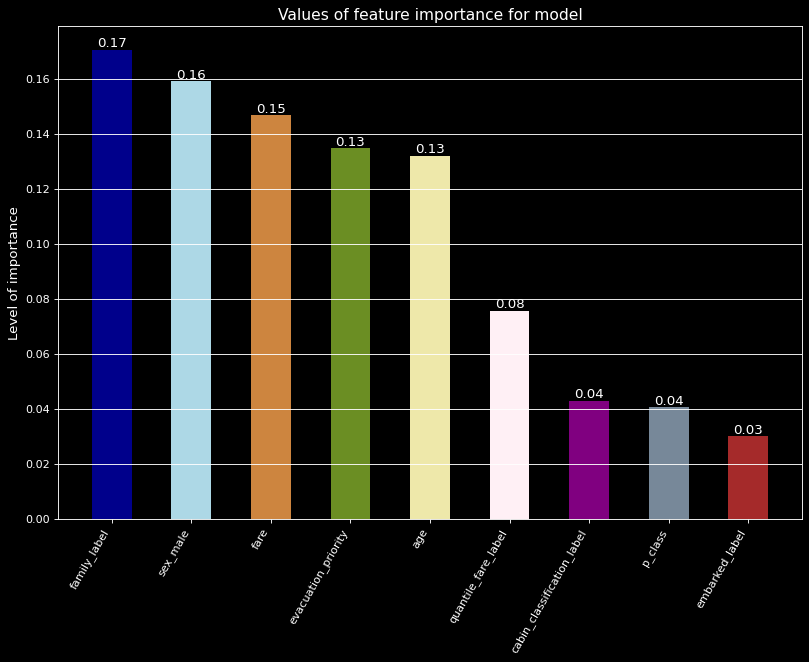

In [82]:
features_forest, best_features_forest = importance_and_auc_roc(RandomForestClassifier)

Model:
 <class 'sklearn.linear_model._logistic.LogisticRegression'>
AUC-ROC value for model from the box:
 0.84
Table of feature importance for algoritm


,feature,importance
0,sex_male,1.996969
1,quantile_fare_label,0.286859
2,random_feature,0.184645
3,alone_yes,0.176276
4,evacuation_priority,0.152970
5,p_class,0.133687
6,embarked_label,0.132857
7,age,0.126400
8,age_group_label,0.120038
9,fare,0.085757


The most important features (all above the random_feature or in request):



,feature,importance
0,sex_male,1.996969
1,quantile_fare_label,0.286859
2,random_feature,0.184645
3,alone_yes,0.176276
4,evacuation_priority,0.152970
5,p_class,0.133687
6,embarked_label,0.132857


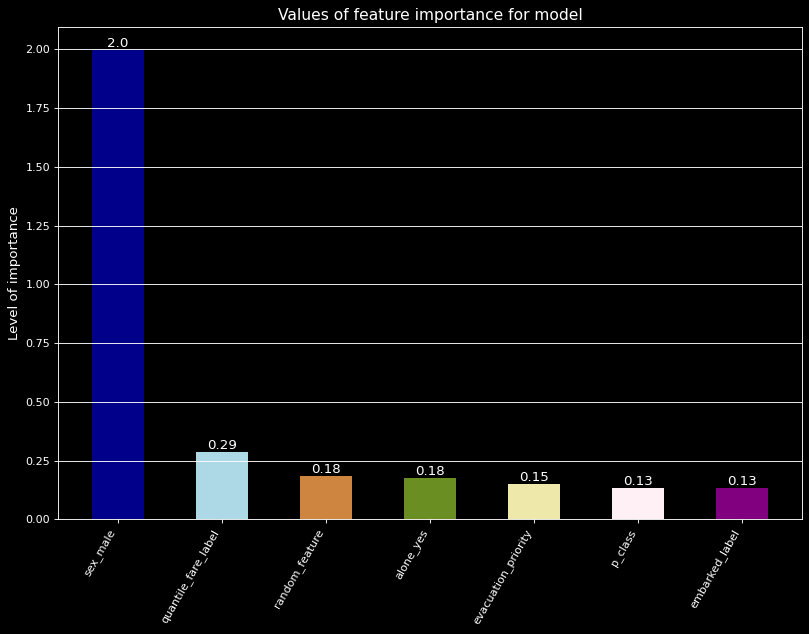

In [83]:
features_lr, best_features_lr = importance_and_auc_roc(LogisticRegression, 7)

In [84]:
features_lr = features_lr.drop(columns='random_feature')

Model:
 <class 'lightgbm.sklearn.LGBMClassifier'>
AUC-ROC value for model from the box:
 0.85
Table of feature importance for algoritm


,feature,importance
0,family_label,1037
1,fare,760
2,age,588
3,cabin_classification_label,102
4,quantile_fare_label,101
5,random_feature,99
6,embarked_label,79
7,sex_male,69
8,evacuation_priority,49
9,alone_yes,42


The most important features (all above the random_feature or in request):



,feature,importance
0,family_label,1037
1,fare,760
2,age,588
3,cabin_classification_label,102
4,quantile_fare_label,101
5,random_feature,99
6,embarked_label,79
7,sex_male,69


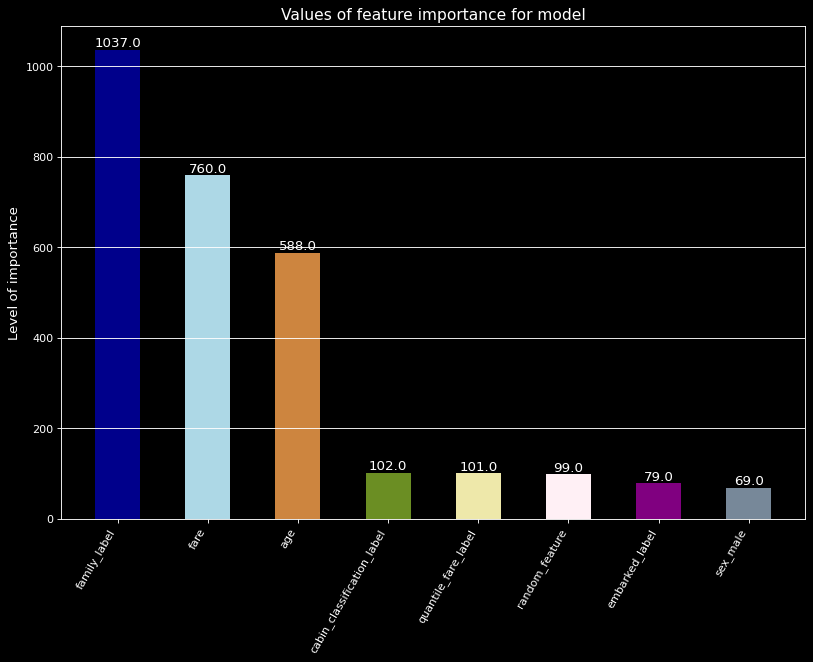

In [85]:
features_lgbmc, best_features_lgbmc = importance_and_auc_roc(LGBMClassifier, 8)

In [86]:
features_lgbmc = features_lgbmc.drop(columns='random_feature')

Model:
 <class 'xgboost.sklearn.XGBClassifier'>
AUC-ROC value for model from the box:
 0.84
Table of feature importance for algoritm


,feature,importance
0,sex_male,0.501622
1,quantile_fare_label,0.128126
2,cabin_classification_label,0.079726
3,p_class,0.040652
4,alone_yes,0.039641
5,fare,0.038944
6,evacuation_priority,0.036212
7,age,0.032670
8,family_label,0.030509
9,age_group_label,0.026276


The most important features (all above the random_feature or in request):



,feature,importance
0,sex_male,0.501622
1,quantile_fare_label,0.128126
2,cabin_classification_label,0.079726
3,p_class,0.040652
4,alone_yes,0.039641
5,fare,0.038944
6,evacuation_priority,0.036212
7,age,0.032670
8,family_label,0.030509
9,age_group_label,0.026276


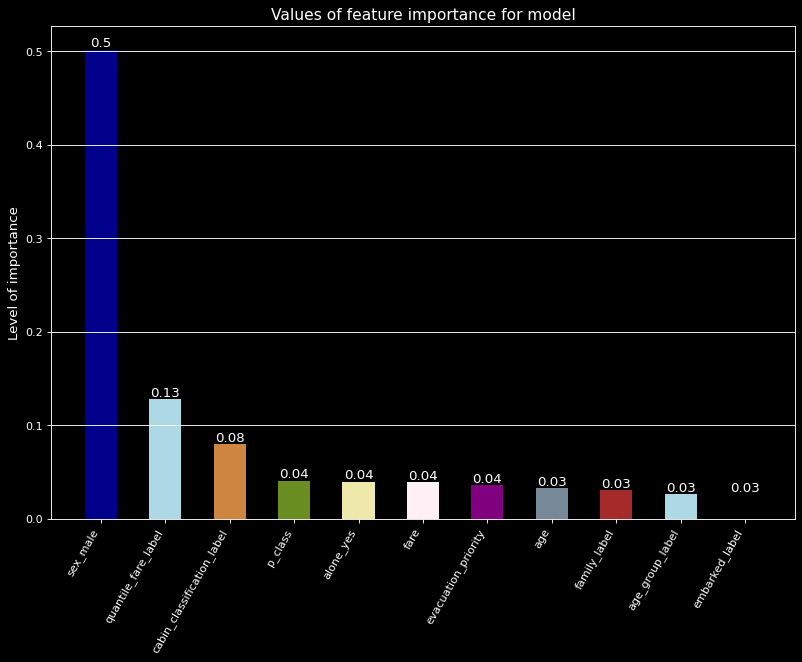

The most important features for the algoritm using included tools


<Figure size 1200x800 with 0 Axes>

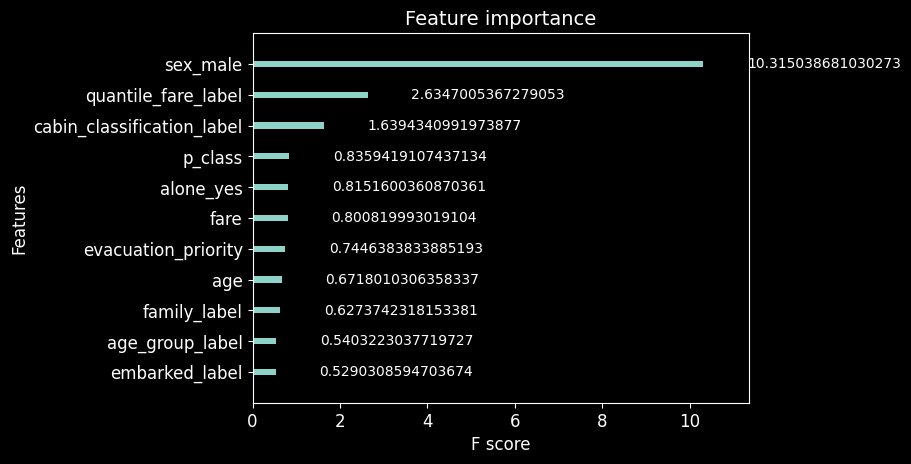

In [87]:
features_xgbc, best_features_xgbc = importance_and_auc_roc(XGBClassifier)

Model:
 <class 'catboost.core.CatBoostClassifier'>
AUC-ROC value for model from the box:
 0.86
Table of feature importance for algoritm


,feature,importance
0,sex_male,15.788273
1,fare,14.125098
2,family_label,13.897539
3,evacuation_priority,10.103452
4,age,9.464445
5,quantile_fare_label,8.814753
6,p_class,6.843240
7,embarked_label,5.606541
8,cabin_classification_label,5.033039
9,age_group_label,3.973029


The most important features (all above the random_feature or in request):



,feature,importance
0,sex_male,15.788273
1,fare,14.125098
2,family_label,13.897539
3,evacuation_priority,10.103452
4,age,9.464445
5,quantile_fare_label,8.814753
6,p_class,6.843240
7,embarked_label,5.606541
8,cabin_classification_label,5.033039
9,age_group_label,3.973029


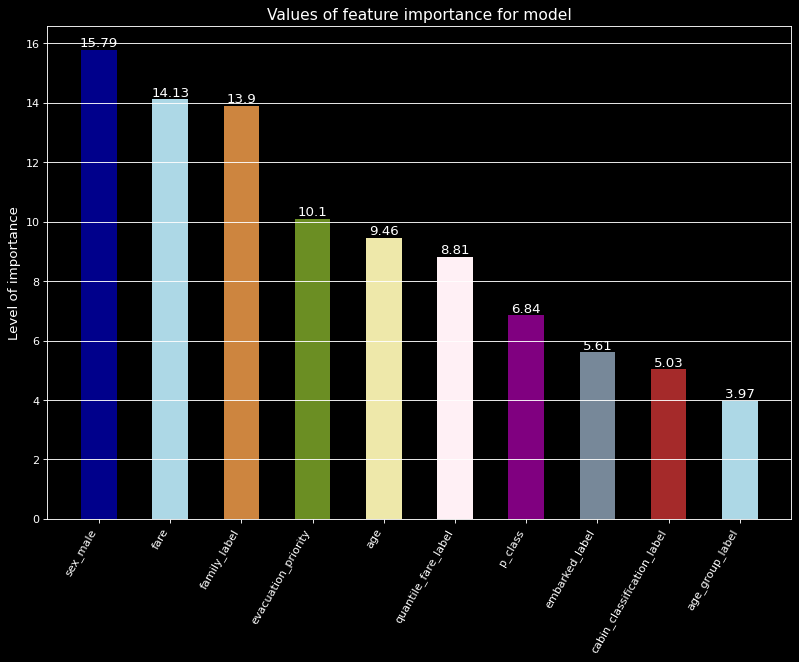

In [88]:
features_catbcl, best_features_catbcl = importance_and_auc_roc(CatBoostClassifier)

### Conclusions of the analytical part

During the analysis, preprocessing and research of the provided data, the following conclusions were made:
- no duplicates or omissions were found;
- all the gaps were processed and filled in with values close to the groups
- qualitative and quantitative signs are analyzed;
- statistically significant signs have been identified and indicators of the impact of each on the possibility of passenger survival have been analyzed;
- it was noted that the evacuation of people took place mainly according to the agreed order - first women and children, passengers with children, and at the end the elderly;
- there is an imbalance of classes in the provided database;
  
- the general statistics of passengers of the ship is collected:
    - Among all the passengers on board:
        * almost `62%` of the first class survived, 
        * `47%` of the second 
        * and only `24%` of the third class. 

This distribution of deaths is primarily due to the placement of cabins of different classes on the ship: the lower the service status, the lower the deck. Most of the dead most likely did not even reach the lifeboats.

- Most of the single passengers (`68%`) without children (`76%`) are mainly young people from 18 to 35 years old (`61%`).
- However, during the disaster, 90% of all children on board were saved due to the evacuation order.
- A high percentage of survivors turned out to be among first-class passengers with a significant fortune which they were willing to spend and economy class with average income - there is an assumption that during the collision with the iceberg, these people were as usual in some entertainment institution - restaurant, casino and so on.
- `72%` of all passengers boarded at point S, `51%` of them survived.
- According to statistics the evacuation of passengers took place in the following order: 
    * first women and children, 
    * passengers with children
    * and last of all the elderly and men of economy class. 
- `74%` of all women survived 
- while `81%` of male passengers died.

## **III. Building models**

The hyperparameter space for searching.

For boosting: less depth, more trees

In [89]:
space_boost = {'max_depth': hp.choice ('max_depth', np.arange(1, 15+1, dtype=int)),
               'n_estimators' : hp.choice ('n_estimators', np.arange(1, 200, dtype=int)),
               'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
               'learning_rate': hp.uniform ('learning_rate', 0, 1)
        }

For a random forest: more depth, fewer trees.

In [90]:
space_forest = {'max_depth': hp.choice ('max_depth', np.arange(1, 500+1, dtype=int)),
                'n_estimators' : hp.choice ('n_estimators', np.arange(1, 40, dtype=int)),
                'min_samples_split' : hp.uniform ('min_samples_split', 0, 1)
        }

### 1. The «Random Forest» model

In [91]:
def best_par_hyperopt(features_train, target_train):

    def objective(space_forest):
        
        model_opt = RandomForestClassifier(random_state=random_state, 
                                           max_depth = space_forest['max_depth'], 
                                           n_estimators = space_forest['n_estimators'],
                                           criterion = 'entropy',
                                           min_samples_split = space_forest['min_samples_split'],
                                           class_weight = 'balanced'
                                     )
    
        model_opt.fit(features_train, target_train)
        
        crossval_scores = round(cross_val_score(model_opt, features_train, target_train, scoring='roc_auc', cv=11).mean(), 3)

        return {'loss': -crossval_scores, 'status': STATUS_OK }
    
    trials = Trials()
    best = fmin(fn= objective,
            space= space_forest,
            algo= tpe.suggest,
            max_evals = 100,
            trials= trials,
            show_progressbar=True)
    
    print(best)
    
    # we mark the time for training the best model
    start_time = time.time()
    
    best_model = RandomForestClassifier(random_state=random_state, 
                                        max_depth = best['max_depth'], 
                                        n_estimators = best['n_estimators'],
                                        criterion = 'entropy',
                                        min_samples_split = best['min_samples_split'],
                                        class_weight = 'balanced'
                                       )

    best_model.fit(features_train, target_train)
        
    roc_auc_best = round(cross_val_score(best_model, features_train, target_train, scoring='roc_auc', cv=11).mean(), 2)

    model_time = round((time.time() - start_time), 5)
    
    print(f'The training execution time with the best parameters is {model_time:.3f} sec')

    return best, model_time, roc_auc_best, best_model

In [92]:
best_forest_param, best_forest_time, best_forest_roc_auc, best_forest_model = (
    best_par_hyperopt(features_forest, target))

print('Roc_auc value is', best_forest_roc_auc)

100%|███████████████████| 100/100 [00:26<00:00,  3.76trial/s, best loss: -0.871]
{'max_depth': 382, 'min_samples_split': 0.014922228660580463, 'n_estimators': 27}
The training execution time with the best parameters is 0.419 sec
Roc_auc value is 0.87


### 2. The «Logistic regression» model

In [93]:
features_lr.head(3)

,sex_male,quantile_fare_label,alone_yes,evacuation_priority,p_class,embarked_label
0,1,6.0,1,7,3,2.0
1,0,2.0,1,1,1,0.0
2,0,8.0,0,3,3,2.0


interval columns not set, guessing: ['sex_male', 'quantile_fare_label', 'alone_yes', 'evacuation_priority', 'p_class', 'embarked_label']
interval columns not set, guessing: ['sex_male', 'quantile_fare_label', 'alone_yes', 'evacuation_priority', 'p_class', 'embarked_label']
interval columns not set, guessing: ['sex_male', 'quantile_fare_label', 'alone_yes', 'evacuation_priority', 'p_class', 'embarked_label']


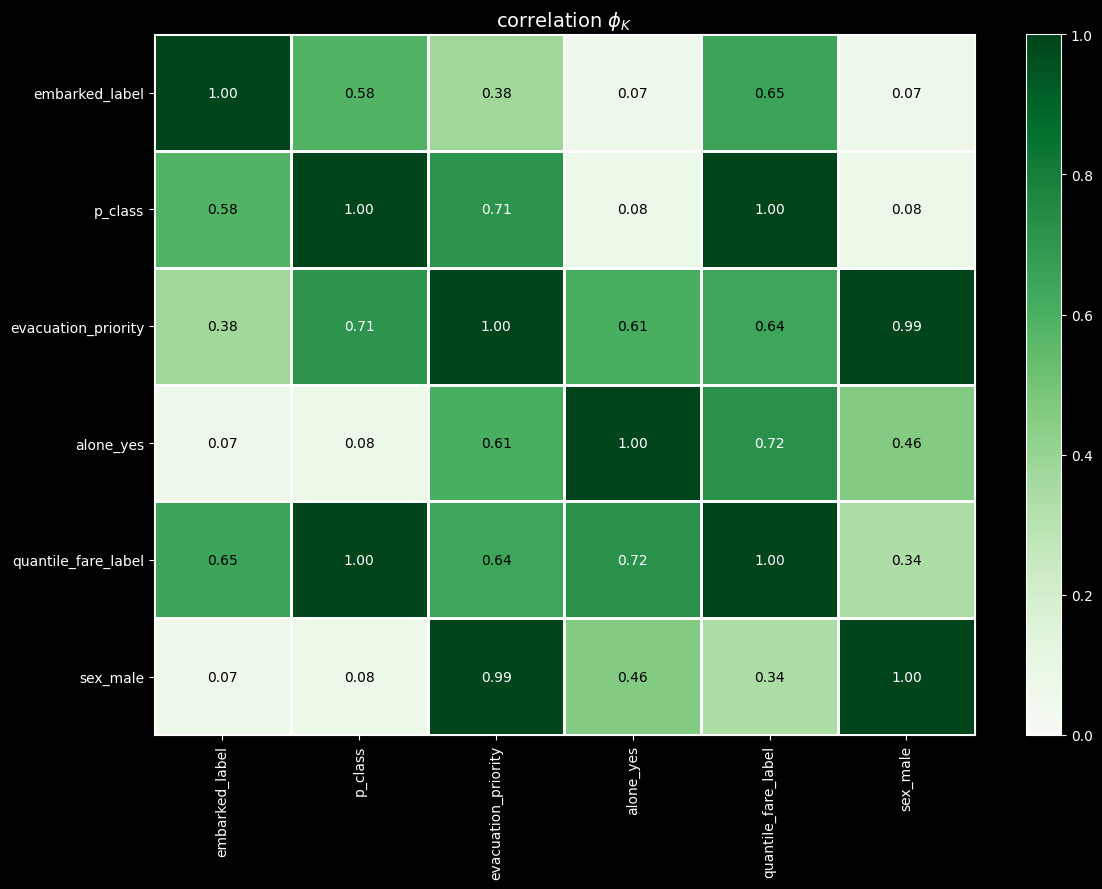

In [94]:
plot_correlation_matrix(features_lr.phik_matrix().values, 
                        x_labels=features_lr.phik_matrix().columns, 
                        y_labels=features_lr.phik_matrix().index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.0, 
                        figsize=(12, 9))
plt.tight_layout()

In [95]:
features_lr = pd.get_dummies(features_lr, columns=['p_class', 'quantile_fare_label', 'evacuation_priority', 'embarked_label'], drop_first=False)
features_lr.head(3)

,sex_male,alone_yes,p_class_1,p_class_2,p_class_3,quantile_fare_label_0.0,quantile_fare_label_1.0,quantile_fare_label_2.0,quantile_fare_label_3.0,quantile_fare_label_4.0,...,evacuation_priority_1,evacuation_priority_2,evacuation_priority_3,evacuation_priority_4,evacuation_priority_5,evacuation_priority_6,evacuation_priority_7,embarked_label_0.0,embarked_label_1.0,embarked_label_2.0
0,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,0,1,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [96]:
model_lr = LogisticRegression(random_state=random_state)

params = {'C': [0.1, 0.2, 0.5, 0.7, 1, 2, 5, 10, 15, 20]}

for i in tqdm(range(len(list(params.get('C'))) * 11)):
    g_cv_lr = GridSearchCV(estimator=model_lr, 
                           param_grid=params, 
                           scoring='roc_auc',
                           cv=11,
                           n_jobs=1,
                           refit=False)
    
    g_cv_lr.fit(features_lr, target)

best_lr_param = g_cv_lr.best_params_


# we mark the time for training the best model
start_time = time.time()
best_g_cv_lr_model = LogisticRegression(random_state=random_state,
                                        solver='lbfgs',
                                        C=g_cv_lr.best_params_.get('C'),
                                        class_weight = 'balanced').fit(features_lr, target)

best_lr_roc_auc = round(g_cv_lr.best_score_, 2)

best_lr_time = round((time.time() - start_time), 5)

print(best_lr_param)

print(f'The training execution time with the best parameters is {best_lr_time:.3f} sec')
print('Roc_auc value is', best_lr_roc_auc)

  0%|          | 0/110 [00:00<?, ?it/s]

{'C': 0.1}
The training execution time with the best parameters is 0.019 sec
Roc_auc value is 0.84


### 3. The LightGBM model

In [97]:
def best_par_hyperopt(features_train, target_train):

    def objective(space_boost):

        model_opt = LGBMClassifier(random_state=random_state, 
                                   max_depth = space_boost['max_depth'], 
                                   n_estimators = space_boost['n_estimators'],
                                   learning_rate = space_boost['learning_rate']
                                  )

        model_opt.fit(features_train, target_train, verbose=0)

        crossval_scores = round(cross_val_score(model_opt, features_train, target_train, scoring='roc_auc', cv=11).mean(), 3)

        return {'loss': -crossval_scores, 'status': STATUS_OK }

    trials = Trials()
    best = fmin(fn= objective,
            space= space_boost,
            algo= tpe.suggest,
            max_evals = 100,
            trials= trials,
            show_progressbar=True)

    print(best)

    # we mark the time for training the best model
    start_time = time.time()

    best_model = LGBMClassifier(random_state=random_state, 
                                max_depth = best['max_depth'],
                                n_estimators = best['n_estimators'],
                                learning_rate = best['learning_rate']
                               )

    best_model.fit(features_train, target_train, verbose=0)

    roc_auc_best = round(cross_val_score(best_model, features_train, target_train, scoring='roc_auc', cv=11).mean(), 2)

    model_time = round((time.time() - start_time), 5)

    print(f'The training execution time with the best parameters is {model_time:.3f} sec')

    return best, model_time, roc_auc_best, best_model

In [98]:
best_lgbmc_param, best_lgbmc_time, best_lgbmc_roc_auc, best_lgbmc_model = (
    best_par_hyperopt(features_lgbmc, target))

print('Roc_auc value', best_lgbmc_roc_auc)

100%|███████████████████| 100/100 [19:36<00:00, 11.76s/trial, best loss: -0.862]
{'learning_rate': 0.4045456356791009, 'max_depth': 1, 'min_samples_split': 0.7098743348679871, 'n_estimators': 56}
The training execution time with the best parameters is 0.954 sec
Roc_auc value 0.85


### 4. The XGBoost model

In [99]:
def best_par_hyperopt(features_train, target_train):

    def objective(space_boost):
        
        model_opt = XGBClassifier(random_state=random_state, 
                                      max_depth = space_boost['max_depth'], 
                                      n_estimators = space_boost['n_estimators'],
                                      eval_metric='logloss'
                                     )
    
        model_opt.fit(features_train, target_train)
        
        crossval_scores = round(cross_val_score(model_opt, features_train, target_train, scoring='roc_auc', cv=11).mean(), 3)

        return {'loss': -crossval_scores, 'status': STATUS_OK }
    
    trials = Trials()
    best = fmin(fn= objective,
            space= space_boost,
            algo= tpe.suggest,
            max_evals = 50,
            trials= trials,
            show_progressbar=True)
    
    print(best)

    # we mark the time for training the best model
    start_time = time.time()
    
    best_model = XGBClassifier(random_state=random_state, 
                                   max_depth = best['max_depth'],
                                   eval_metric='logloss',
                                   n_estimators = best['n_estimators']
                                  )
    
    best_model.fit(features_train, target_train)
    

    
    roc_auc_best = round(cross_val_score(best_model, features_train, target_train, scoring='roc_auc', cv=11).mean(), 2)

    model_time = round((time.time() - start_time), 5)
    
    print(f'The training execution time with the best parameters is {model_time:.3f} sec')

    return best, model_time, roc_auc_best, best_model

In [100]:
best_xgbc_param, best_xgbc_time, best_xgbc_roc_auc, best_xgbc_model = (
    best_par_hyperopt(features_xgbc, target))

print('Roc_auc value is', best_xgbc_roc_auc)

100%|██████████████████████| 50/50 [06:12<00:00,  7.45s/trial, best loss: -0.86]
{'learning_rate': 0.37924584331384104, 'max_depth': 1, 'min_samples_split': 0.9966032882120323, 'n_estimators': 17}
The training execution time with the best parameters is 0.449 sec
Roc_auc value is 0.85


### 5. The CatBoost model

In [101]:
def best_par_hyperopt(features_train, target_train):

    def objective(space_boost):
        
        model_opt = CatBoostClassifier(random_state=random_state, 
                                       verbose=0,
                                       max_depth = space_boost['max_depth'], 
                                       n_estimators = space_boost['n_estimators']
                                      )
    
        model_opt.fit(features_train, target_train)
        
        crossval_scores = round(cross_val_score(model_opt, features_train, 
                                                target_train, scoring='roc_auc', 
                                                cv=11, verbose=0).mean(), 3)

        return {'loss': -crossval_scores, 'status': STATUS_OK }
    
    trials = Trials()
    best = fmin(fn= objective,
            space= space_boost,
            algo= tpe.suggest,
            max_evals = 50,
            trials= trials,
            show_progressbar=True)
    
    print(best)

    # we mark the time for training the best model
    start_time = time.time()
    
    best_model = CatBoostClassifier(random_state=random_state,
                                    verbose=0,
                                    max_depth = best['max_depth'],
                                    n_estimators = best['n_estimators']
                                   )
    
    best_model.fit(features_train, target_train)
    

    
    roc_auc_best = round(cross_val_score(best_model, features_train, 
                                         target_train, scoring='roc_auc', 
                                         cv=11, verbose=0).mean(), 2)

    model_time = round((time.time() - start_time), 5)
    
    print(f'The training execution time with the best parameters is {model_time:.3f} sec')

    return best, model_time, roc_auc_best, best_model

In [102]:
best_catbcl_param, best_catbcl_time, best_catbcl_roc_auc, best_catbcl_model = (
    best_par_hyperopt(features_catbcl, target))

print('Roc_auc value is', best_catbcl_roc_auc)

100%|█████████████████████| 50/50 [06:55<00:00,  8.31s/trial, best loss: -0.866]
{'learning_rate': 0.5695669554159404, 'max_depth': 4, 'min_samples_split': 0.022330838609865622, 'n_estimators': 135}
The training execution time with the best parameters is 0.701 sec
Roc_auc value is 0.86


### Interim result

We received the following data on the best models in training

In [103]:
# add all models to the dictionary for quick access to the name and the model itself
models = {'RandomForest' : best_forest_model,
          'LogisticRegression' : best_g_cv_lr_model,
          'LGBMClassifier' : best_lgbmc_model,
          'XGBClassifier' : best_xgbc_model,
          'CatBoostClassifier' : best_catbcl_model
         }

models_description = [
    ['RandomForest',best_forest_roc_auc, best_forest_time, best_forest_param],
    ['LogisticRegression', best_lr_roc_auc, best_lr_time, best_lr_param],
    ['LGBMClassifier', best_lgbmc_roc_auc, best_lgbmc_time, best_lgbmc_param],
    ['XGBClassifier', best_xgbc_roc_auc, best_xgbc_time, best_xgbc_param],
    ['CatBoostClassifier', best_catbcl_roc_auc, best_catbcl_time, best_catbcl_param]
]

columns_models_description = ['Model', 'Best roc_auc value due to train', 
                              'Execution time of the optimal parameter, sec.', 'The best hyperparameters']

models_summary = pd.DataFrame(data=models_description, columns=columns_models_description)
pd.set_option('display.max_colwidth', None)
models_summary.sort_values(by='Best roc_auc value due to train', ascending=False)

,Model,Best roc_auc value due to train,"Execution time of the optimal parameter, sec.",The best hyperparameters
0,RandomForest,0.87,0.41865,"{'max_depth': 382, 'min_samples_split': 0.014922228660580463, 'n_estimators': 27}"
4,CatBoostClassifier,0.86,0.70148,"{'learning_rate': 0.5695669554159404, 'max_depth': 4, 'min_samples_split': 0.022330838609865622, 'n_estimators': 135}"
2,LGBMClassifier,0.85,0.95355,"{'learning_rate': 0.4045456356791009, 'max_depth': 1, 'min_samples_split': 0.7098743348679871, 'n_estimators': 56}"
3,XGBClassifier,0.85,0.44941,"{'learning_rate': 0.37924584331384104, 'max_depth': 1, 'min_samples_split': 0.9966032882120323, 'n_estimators': 17}"
1,LogisticRegression,0.84,0.01920,{'C': 0.1}


In total the best model for the learning outcome is `RandomForest` with a quality of `roc_auc 0.87` and an average learning time.

In [104]:
best_model_name = 'RandomForest'

best_model = models.get(best_model_name)

best_model_summary = models_summary[models_summary['Model'] == best_model_name]
best_model_summary

,Model,Best roc_auc value due to train,"Execution time of the optimal parameter, sec.",The best hyperparameters
0,RandomForest,0.87,0.41865,"{'max_depth': 382, 'min_samples_split': 0.014922228660580463, 'n_estimators': 27}"


In [105]:
prediction = best_model.predict(features_forest)
report = classification_report(target, prediction)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       549
           1       0.90      0.86      0.88       340

    accuracy                           0.91       889
   macro avg       0.91      0.90      0.91       889
weighted avg       0.91      0.91      0.91       889



### **6. Checking the best model on a test sample**

Let's check our best model on a test sample to make sure of its quality

In [106]:
test_forest = test[features_forest.columns]

In [107]:
final_pred = best_model.predict(test_forest)

In [108]:
results = pd.read_csv('/Users/vi_gav/Desktop/Py_projects/jupyter/titanic/datasets/test.csv')
results['Survived']=final_pred
results = results[['PassengerId','Survived']]

In [109]:
results.to_csv('disaster.csv', index=False)

**The result аo roc_auc value on the test sample is 0.7751**

Let 's print the final table again

In [110]:
best_model_summary['Best roc_auc value due to test'] = 0.77
best_model_summary

,Model,Best roc_auc value due to train,"Execution time of the optimal parameter, sec.",The best hyperparameters,Best roc_auc value due to test
0,RandomForest,0.87,0.41865,"{'max_depth': 382, 'min_samples_split': 0.014922228660580463, 'n_estimators': 27}",0.77


Let's build a matrix of errors

In [113]:
try:
    target_test = pd.read_csv('../input/titanic/target_test.csv')
except:
    target_test = open_csv_file('target_test', 'ykGIo9enSXNhzA')


File target_test.csv was read from your laptop
_______________________________________________________________________________________________________________________________________


In [114]:
target_test = target_test['Survived']

In [115]:
# building the error matrix of the best model

predict = best_model.predict(test_forest)
matrix = confusion_matrix(target_test, predict)
print('\033[4m\033[1m\033[31m{}\033[0m\n'
      .format('Error matrix for best model:'), matrix)

Error matrix for best model:
 [[210  50]
 [ 52 106]]


We will also construct a ROC curve. Horizontally, we plot the proportion of false positive responses (FPR), and vertically — the proportion of true positive responses (TPR). Let's build an error curve for our better `RandomForest` model and compare it with a model that always responds randomly (a straight diagonal). Accordingly, the higher our curve, the greater the TPR completeness value and the better the model quality.

In [116]:
def roc_curve_plot(model, model_name, features_model):
    probabilities_test = model.predict_proba(test_forest[list(features_model.columns)])
    probabilities_one_test = probabilities_test[:, 1]

    fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

    plt.figure(figsize=[12,9])

    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    # ROC curve of a random model (looks like a straight line)
    plt.plot([0, 1], [0, 1], linestyle='--')

    plt.xlabel('False Positive Rate', fontsize = 12)
    plt.ylabel('True Positive Rate', fontsize = 12)
    plt.title(f'ROC-curve {model_name}', fontsize = 14)
    plt.legend([model_name, 'Random_model'], fontsize=13)

    plt.show()

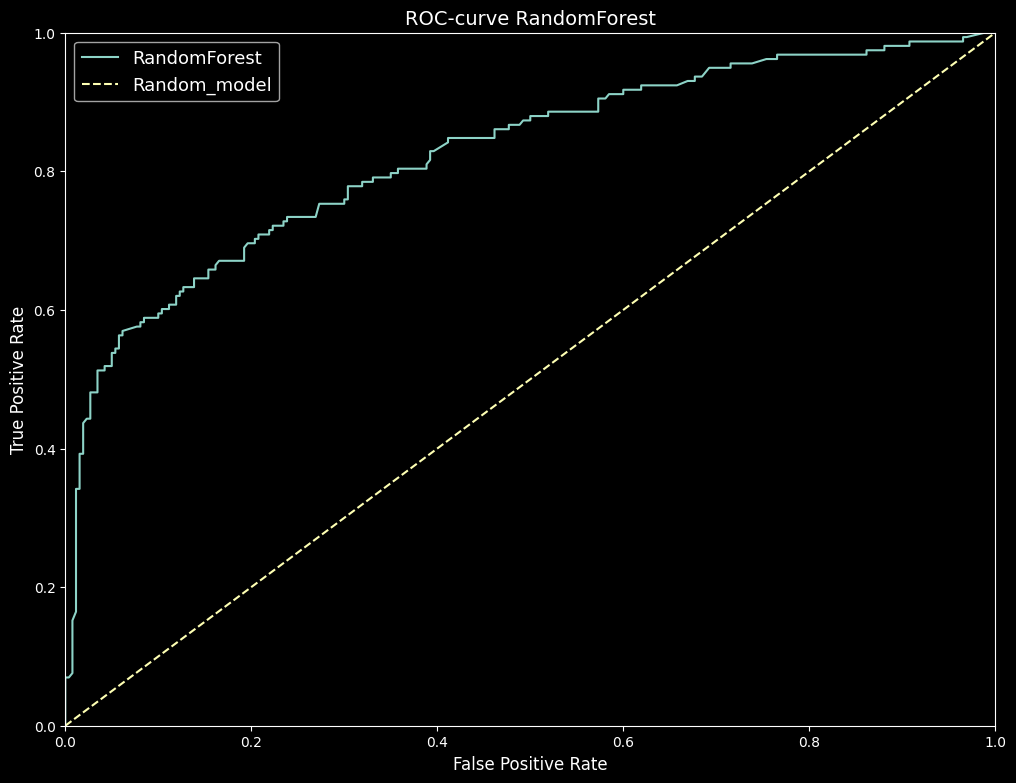

In [117]:
roc_curve_plot(best_model, best_model_name, features_forest)

### **7. Checking the model for sanity**

In [118]:
features_ok = abs(features.drop(columns=['random_feature'], axis=1))

In [119]:
features_test_ok = abs(test_forest)

#### **7.1 DummyClassifier**

We will also check the model for adequacy by comparing it with random results that ignore the input data rule. And if the model behaves better it means it can extract some signal from the data and has predictive power. To do this we'll use `sklearn.dummy.DummyClassifier`

In [120]:
dummy_cls = DummyClassifier(strategy="uniform")
dummy_cls.fit(features_ok, target)

dummy_roc_auc = round(cross_val_score(dummy_cls, features_test_ok, target_test, scoring='roc_auc', cv=11).mean(), 2)

print(f'roc_auc DummyClassifier: {dummy_roc_auc}')

roc_auc DummyClassifier: 0.5


#### **7.2 Naive Bayesian Classifier**

Initialize the Naive Bayesian Classifier and run our data

In [121]:
model_bayes = MultinomialNB().fit(features_ok, target)

bayes_roc_auc = round(cross_val_score(model_bayes, features_test_ok, target_test, scoring='roc_auc', cv=11).mean(), 2)

print(f'roc_auc BayesClassifier: {bayes_roc_auc}')

roc_auc BayesClassifier: 0.72


### Conclusions of the model building section

Based on the results of testing on test data:
* our selected RandomForest model showed the best quality of `roc_auc 0.77` on the test with optimal time and hyperparameters:
    - `max_depth`: 101,
    - `min_samples_split`: 0.006580798652501867, 
    - `n_estimators`: 23;
* the result of a random model on a test sample is approximately 50% which proves the sanity of our considered model in comparison with the one we selected
* we compared the result of the prediction accuracy of our best model with the Naive Bayesian Classifier and saw that we got a very good result on the selected model.

## **IV. Results of the research**

<font color=#008B8B> **During the analysis, preprocessing and research of the provided data, the following conclusions were made:** </font>

- no duplicates or omissions were found;
- all the gaps were processed and filled in with values close to the groups
- qualitative and quantitative signs are analyzed;
- statistically significant signs have been identified and indicators of the impact of each on the possibility of passenger survival have been analyzed;

---

<font color=#DC143C> **General conclusions based on statistics are made:** </font>
- it was noted that the evacuation of people took place mainly according to the agreed order - first women and children, passengers with children, and at the end the elderly;
- there is an imbalance of classes in the provided database;
  
- the general statistics of passengers of the ship is collected:
    - Among all the passengers on board:
        * almost `62%` of the first class survived, 
        * `47%` of the second 
        * and only `24%` of the third class. 

This distribution of deaths is primarily due to the placement of cabins of different classes on the ship: the lower the service status, the lower the deck. Most of the dead most likely did not even reach the lifeboats.

---

<font color=#FFD700> **Additional patterns have also been identified based on the results of data processing** </font>

- Most of the single passengers (`68%`) without children (`76%`) are mainly young people from 18 to 35 years old (`61%`).
- However, during the disaster, 90% of all children on board were saved due to the evacuation order.
- A high percentage of survivors turned out to be among first-class passengers with a significant fortune which they were willing to spend and economy class with average income - there is an assumption that during the collision with the iceberg, these people were as usual in some entertainment institution - restaurant, casino and so on.
- `72%` of all passengers boarded at point S, `51%` of them survived.
- According to statistics the evacuation of passengers took place in the following order: 
    * first women and children, 
    * passengers with children
    * and last of all the elderly and men of economy class. 
- `74%` of all women survived 
- while `81%` of male passengers died.

Based on the processed data we created several models, selected optimal hyperparameters, selected the best one and tested it on a test sample. And that's what we got:

In [123]:
best_model_summary

,Model,Best roc_auc value due to train,"Execution time of the optimal parameter, sec.",The best hyperparameters,Best roc_auc value due to test
0,RandomForest,0.87,0.41865,"{'max_depth': 382, 'min_samples_split': 0.014922228660580463, 'n_estimators': 27}",0.77


The favorite of the roc_auc metric is RandomForest. The model is trained on the following list of features with an indicator of their importance to the model

,feature,importance
0,family_label,0.170668
1,sex_male,0.159255
2,fare,0.146871
3,evacuation_priority,0.134890
4,age,0.131999
5,quantile_fare_label,0.075659
6,cabin_classification_label,0.043000
7,p_class,0.040692
8,embarked_label,0.029981


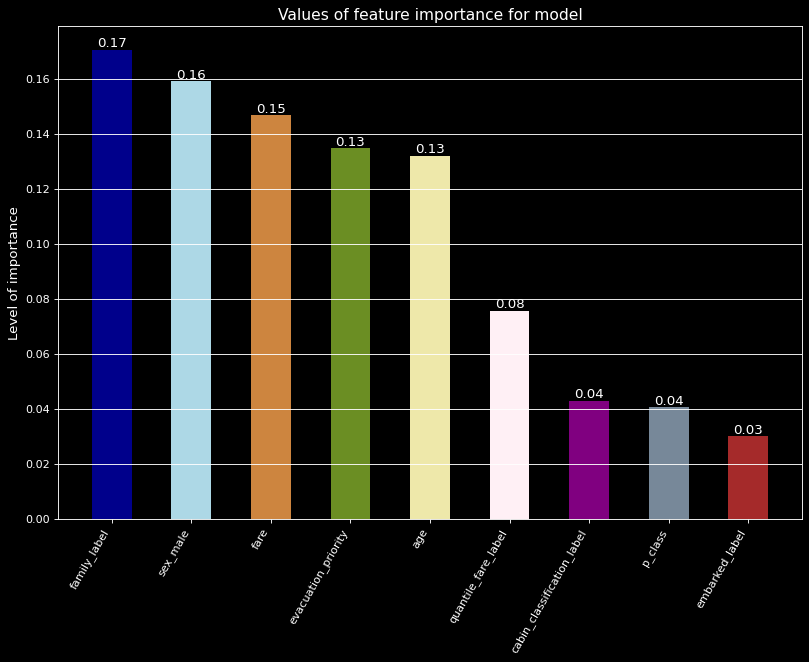

In [124]:
display(best_features_forest)
print()
bars_importance(best_features_forest)

Error matrix for best model:
 [[210  50]
 [ 52 106]] 



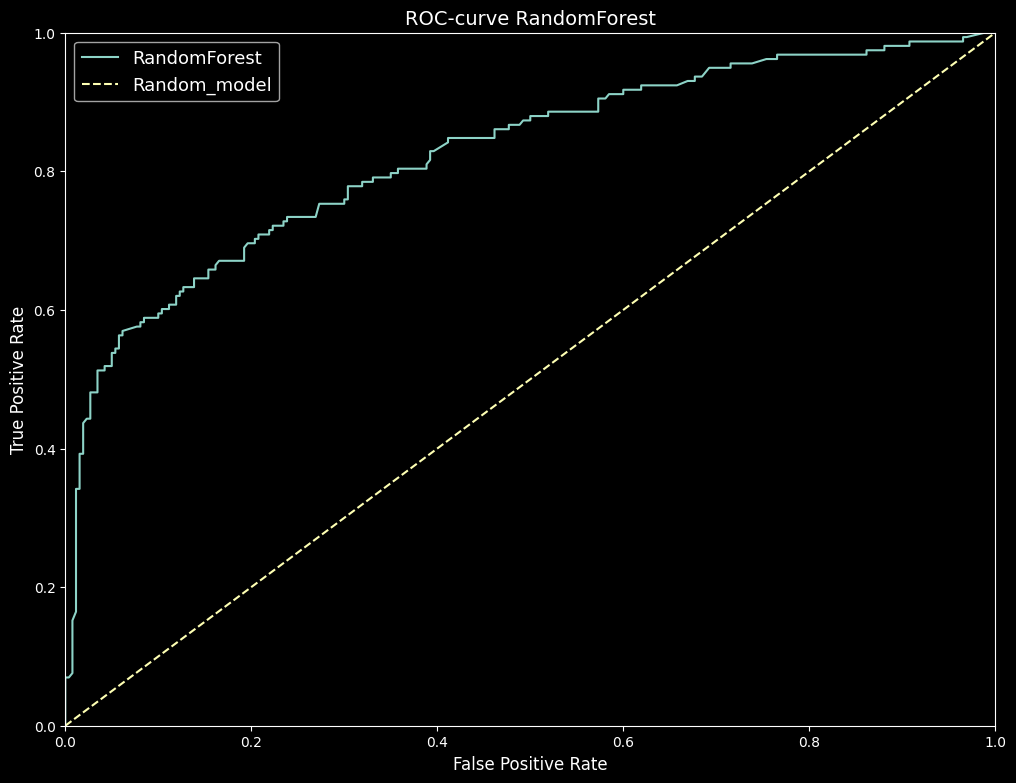

In [125]:
print('\033[4m\033[1m\033[31m{}\033[0m\n'
      .format('Error matrix for best model:'), matrix, '\n')

roc_curve_plot(best_model, best_model_name, features_forest)